# Create the Environment 

Our environment contains one agent, one dynamic obstacle and one moving goal.  
Here, we initialize a 300 * 200 room with simple-playground.

In [698]:
from simple_playgrounds.playground.layouts import SingleRoom
from simple_playgrounds.engine import Engine
from simple_playgrounds.agent.controllers import Keyboard, External
from simple_playgrounds.agent.agents import BaseAgent, HeadAgent
from simple_playgrounds.device.sensors import RgbCamera, Lidar, SemanticCones, Touch
from simple_playgrounds.agent.agent import Agent
from simple_playgrounds.device.sensor import SensorDevice
from simple_playgrounds.element.elements.basic import Physical
import numpy as np
from numpy import pi

# to display the sensors
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

def plt_image(img):
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    

In [699]:
import math
my_playground = SingleRoom(size=(300, 200))
initial_position = (50,50)
# initial_goal = (250, 170)
initial_goal_2 = (220, 60)

## Adding agents and sensors

Here, we add our agent, the obstacle and the goal.  
Our agent perceive its surrondings with a lidar sensor and a touch sensor.

In [700]:
my_agent = BaseAgent(controller=External(), interactive = True, radius = 10, lateral = True)
goal = BaseAgent(controller=External(), interactive = False, radius = 10)
my_agent.add_sensor(Touch(my_agent.base_platform, normalize = True, invisible_elements=my_agent.parts + goal.parts))
obstacle = BaseAgent(controller=External(), interactive = False, radius = 10)
my_agent.add_sensor(Lidar(my_agent.base_platform, normalize = True, invisible_elements=my_agent.parts + goal.parts))

my_playground.add_agent(my_agent, (initial_position, 1.5*pi/4))
my_playground.add_agent(obstacle, ((110,60), pi/2))
my_playground.add_agent(goal, (initial_goal_2, pi/2))

## Define some helper functions

In [701]:
# Convert the sensor values from 2d array to 1d
def array2d_to_1d(array_2d):
    array1d = np.zeros(len(array_2d))
    for i in range(len(array_2d)):
        if len(array_2d[i]) == 1:
            array1d[i] = array_2d[i][0] 
    return array1d


# The following functions are used to generate actions for the dynamic obstacle. 
# It takes the obstacle as input, output the actions of the obstacle (dictionary of {(actuator, value)}).

# Trajectory 1 of the obstacle
def generate_obstacle(agent):
    actions = {}
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[1]] = 0.3
    actions[agent.controller.controlled_actuators[0]] = 0.5
    return actions

# Trajectory 2 of the obstacle
def generate_obstacle_2(agent, last_step):
    actions = {}
    l_step = 0
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[0]] = 0.2
    if agent.coordinates[0][1] <= 60:
        l_step = 0.2
    if agent.coordinates[0][1] >= 140: 
        l_step = -0.2
    elif 55 < agent.coordinates[0][1] < 145:
        l_step = last_step
    actions[agent.controller.controlled_actuators[0]] = l_step
    return actions, l_step


# Calculate the distance from our agent to the goal
def dist_to_destination(agent, goal):
    x = agent.coordinates[0][0]
    y = agent.coordinates[0][1]
    dist =((x-goal[0])**2 + (y-goal[1])**2)**(1/2)
    t = ((goal[0])**2 + (goal[1])**2)**(1/2)
    norm_dist = dist / t
    return norm_dist


# Check if the agent is colliding with the obstacle or the wall.
def check_collision(sensor_values, agent):
    collision = False
    max_val = max(sensor_values)
    indices = []
    for i in range(len(sensor_values)):
         if sensor_values[i] == max_val:
                indices.append(i)
    in_front = True
    for ind in indices:
        if 13 <= ind < 27:
            in_front = True
            break

    if max_val > 0.9 and in_front:
        collision = True
    return collision

# Currently we don't use this function
def close_collision(sensor_values, agent):
    collision = False
    max_val = max(sensor_values)
    indices = []
    for i in range(len(sensor_values)):
         if sensor_values[i] == max_val:
                indices.append(i)
    in_front = False
    for ind in indices:
        if 13 <= ind < 27:
            in_front = True
            break

    if max_val > 0.7 and in_front:
        collision = True
    return collision


# Convert the action values from the reinforcement learning algorithms to dictionary of {(actuator, value)}
def custom_actions(action_values, agent):
    actions = {}
    longitudinal_force = action_values[0]
    angular_velocity = action_values[1]
    lateral_force = action_values[2]
    actions[agent.longitudinal_force] = longitudinal_force
    actions[agent.rotation_velocity] = angular_velocity
    actions[agent.lateral_force] = lateral_force
    actions[agent.activate] = 0
    actions[agent.grasp] = 0
    return actions

# Calculate the angle from our agent to the goal
def theta_to_destination(agent, goal):
    x = agent.coordinates[0][0]
    y = agent.coordinates[0][1]
    total = np.arctan((goal[0]-y)/(goal[1]-x))
    theta = np.radians(total) - agent.coordinates[1]
    theta_norm = theta / (2*np.pi)
    return theta_norm


# The following functions are used to generate actions for the moving goal. 
# It takes the goal agent as input, output the actions of the goal (dictionary of {(actuator, value)}).
def goal_moving(agent, last_step):
    actions = {}
    l_step = 0
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[0]] = 0.2
    if agent.coordinates[0][0] <= 100:
        l_step = -0.2
    if agent.coordinates[0][0] >= 250: 
        l_step = 0.2
    elif 95 < agent.coordinates[0][0] < 255:
        l_step = last_step
    actions[agent.controller.controlled_actuators[0]] = l_step
    return actions, l_step

def goal_moving_2(agent, last_step):
    actions = {}
    l_step = 0
    for actuator in agent.controller.controlled_actuators:
        actions[actuator] = 0
    actions[agent.controller.controlled_actuators[0]] = 0.2
    if agent.coordinates[0][1] <= 60:
        l_step = 0.2
    if agent.coordinates[0][1] >= 140: 
        l_step = -0.2
    elif 55 < agent.coordinates[0][1] < 145:
        l_step = last_step
    actions[agent.controller.controlled_actuators[0]] = l_step
    return actions, l_step

In [702]:
import numpy as np
import gym
from gym import spaces
import random

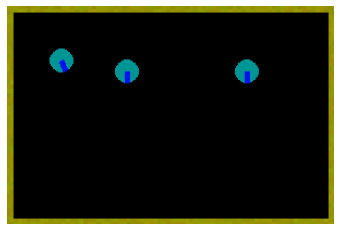

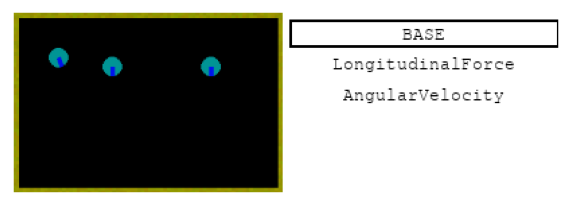

n steps:  45


In [703]:
eng = Engine(time_limit=1000000, playground= my_playground)
eng.update_observations()
plt_image(eng.generate_playground_image())
plt.figure(figsize=(10,10))
plt_image(eng.generate_agent_image(obstacle))


n = random.randint(0,70)
print ("n steps: ", n)
l = 0.2
for i in range(70):
    actions = {}
    actions[eng.agents[0]], l = generate_obstacle_2(eng.agents[0], l)
    eng.step(actions)
    eng.update_observations()
    cv2.imshow('agent', eng.generate_agent_image(eng.agents[0]))
    cv2.waitKey(20)

## Define our environment (Gym Interface)

In [704]:
class myEnv(gym.Env):
#     destination = (170, 170)
    def __init__(self, my_playground):
#         super(myEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        
        self.action_space = spaces.Box(np.array([0, -1, -1]), np.array([1, 1, 1]), dtype=np.float32)
        # The observation will be the coordinate of the agent
        # this can be described both by Discrete and Box space
        self.observation_space = spaces.Box(np.array([-1]+[0]*65), np.array([1]*66), dtype=np.float32)
#         self.observation_space = spaces.Box(low = 0, high = 1, shape = (66,), dtype=np.float32)
        self.engine = Engine(time_limit=100000, playground = my_playground)
        self.threshold = 0.1
        self.last_step = 0.2
        self.goal_initial = [220, 60]
#         self.dist_to_goal = ((initial_position[0] - self.goal_initial[0])**2 + (initial_position[1] - self.goal_initial[1])**2)**(1/2)
        self.goal = [220, 60]
    def reset(self):
        """
        Important: the observation must be a numpy array
        :return: (np.array) 
        """

        eng = self.engine
        eng.reset()
        # For each episode we move the initial position of the obstacle
        n = random.randint(0,70)
        l = 0.2
        for i in range(n):
            actions = {}
            actions[eng.agents[0]] = custom_actions(np.array([0,0,0]), eng.agents[0])
            actions[eng.agents[1]], l = generate_obstacle_2(eng.agents[1], l)
            eng.step(actions)
            eng.update_observations()

        # For each episode we move the initial position of the goal
        m = random.randint(0,70)
        l = 0.2
        for i in range(m):
            actions = {}
            actions[eng.agents[0]] = custom_actions(np.array([0,0,0]), eng.agents[0])
            actions[eng.agents[2]], l = goal_moving_2(eng.agents[2], l)
            eng.step(actions)
            eng.update_observations()
        
        self.goal = []
        self.goal.append(eng.agents[2].coordinates[0][0])
        self.goal.append(eng.agents[2].coordinates[0][1])
        
#         plt_image(eng.generate_playground_image())
#         plt_image(eng.generate_agent_image(eng.agents[0]))

        self.engine = eng
        sensor_vals_lidar = eng.agents[0].sensors[1].sensor_values
#         self.dist_to_goal = ((initial_position[0] - self.goal_initial[0])**2 + (initial_position[1] - self.goal_initial[1])**2)**(1/2)
#         self.goal = [eng.agents[2].coordinates[0][0], eng.agents[2].coordinates[0][1]]
        if sensor_vals_lidar is None:
            sensor_vals_lidar = np.array([0]*64)
        else: 
            sensor_vals_lidar = array2d_to_1d(sensor_vals_lidar)
        
        dist = dist_to_destination(eng.agents[0], self.goal)
        theta = theta_to_destination(eng.agents[0], self.goal)
        obs = np.insert(sensor_vals_lidar, 0, dist)
        obs = np.insert(obs, 0, theta)
        return obs.astype(np.float32)

    def step(self, action_values):
        
        # Here we custom the action_values, generate the "actions" that can be taken by our playground engine
        actions = {}
        eng = self.engine
        actions[eng.agents[0]] = custom_actions(action_values, eng.agents[0])
        actions[eng.agents[2]], l = goal_moving_2(eng.agents[2], self.last_step)
#         actions[eng.agents[1]] = generate_obstacle(eng.agents[1])
        actions[eng.agents[1]], l = generate_obstacle_2(eng.agents[1], self.last_step) 
        self.last_step = l
        
        # Apply the actions 
        eng.step(actions)
        eng.update_observations()

#         cv2.imshow('agent', eng.generate_agent_image(eng.agents[0]))
#         cv2.waitKey(20)
        
        self.engine = eng
        
        # Custom the sensor values and distance to destination after our agent takes action
        sensor_vals_lidar = eng.agents[0].sensors[1].sensor_values
        sensor_vals_lidar = array2d_to_1d(sensor_vals_lidar)
        sensor_vals_touch = eng.agents[0].sensors[0].sensor_values
        sensor_vals_touch = array2d_to_1d(sensor_vals_touch)
        
        self.goal = []
        self.goal.append(eng.agents[2].coordinates[0][0])
        self.goal.append(eng.agents[2].coordinates[0][1])
        dist = dist_to_destination(eng.agents[0], self.goal)
        theta = theta_to_destination(eng.agents[0], self.goal)
        obs = np.insert(sensor_vals_lidar, 0, dist)
        obs = np.insert(obs, 0, theta)
        
#         last_dist = self.dist_to_goal
#         self.dist_to_goal = dist * (((self.goal[0])**2 + (self.goal[1])**2)**(1/2))

        reward = 0
        
        
#         If our agent collides with the obstacle (agent2), then gives reward -1000. 
#         If our agent arrives at the destination, then gives reward 2000.
#         Otherwise, gives reward -1. 
#         This doesn't work for A2C: hard exploration ---> sparse reward problem
        if check_collision(sensor_vals_touch, eng.agents[0]):
            reward = -0.5
#             print ("collision with obstacle!!!")
        if dist < self.threshold:
            reward = 1
#         if action_values[0] < 0.1:
#             reward += -0.3
        reward += -dist



        # Are we at the terminate state?
        done = bool(dist < self.threshold)
        if dist < self.threshold:
            print ("Goal reached!")

        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return obs.astype(np.float32), reward, done, info

    def render(self, mode='console'):
        if mode != 'console':
          raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
#         print("." * self.agent_pos, end="")
#         print("x", end="")
#         print("." * (self.grid_size - self.agent_pos))

    def close(self):
        pass
    

In [705]:
# from stable_baselines import DQN, PPO2, A2C, ACKTR
# from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.env_checker import check_env
# Instantiate the env
# env = myEnv()
# # wrap it
# env = make_vec_env(lambda: env, n_envs=1)

In [706]:
env = myEnv(my_playground)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

/Users/yizhang/opt/anaconda3/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
/Users/yizhang/opt/anaconda3/lib/python3.8/site-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


In [707]:
# Apply reinforcement learning methods
from stable_baselines3 import PPO, A2C, DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import TQC
# Instantiate the env
env = myEnv(my_playground)
# wrap it
env = make_vec_env(lambda: env, n_envs=1)


## Testing RL Algorithms (Box Spaces)

PPO, DDPG, A2C, HER, SAC, TD3, TQC

In [494]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)
# 15_randomstart: goal initial position is constant
# 16: collision -0.5
# 17: collision -0.5 with on random inital position for goal
model.save("PPO_moving_18_randomstart")

Using cpu device
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 448      |
|    ep_rew_mean     | -312     |
| time/              |          |
|    fps             | 430      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 795         |
|    ep_rew_mean          | -667        |
| time/                   |             |
|    fps                  | 410         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008908265 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.25       |

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 347        |
|    ep_rew_mean          | -193       |
| time/                   |            |
|    fps                  | 370        |
|    iterations           | 10         |
|    time_elapsed         | 55         |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.00468361 |
|    clip_fraction        | 0.0512     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.14      |
|    explained_variance   | -5.22e-05  |
|    learning_rate        | 0.0003     |
|    loss                 | 15.2       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.00331   |
|    std                  | 0.961      |
|    value_loss           

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 190         |
|    ep_rew_mean          | -80.1       |
| time/                   |             |
|    fps                  | 352         |
|    iterations           | 18          |
|    time_elapsed         | 104         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.008803792 |
|    clip_fraction        | 0.0839      |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.07       |
|    explained_variance   | 1.79e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 20.1        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0038     |
|    std            

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 114         |
|    ep_rew_mean          | -44.8       |
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 26          |
|    time_elapsed         | 164         |
|    total_timesteps      | 53248       |
| train/                  |             |
|    approx_kl            | 0.008960687 |
|    clip_fraction        | 0.074       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4          |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 63.2        |
|    ep_rew_mean          | -25         |
| time/                   |             |
|    fps                  | 298         |
|    iterations           | 32          |
|    time_elapsed         | 219         |
|    total_timesteps      | 65536       |
| train/                  |             |
|    approx_kl            | 0.009035614 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.95       |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 14          |
|    n_updates      

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.2        |
|    ep_rew_mean          | -21.3       |
| time/                   |             |
|    fps                  | 280         |
|    iterations           | 38          |
|    time_elapsed         | 277         |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 0.009802357 |
|    clip_fraction        | 0.107       |
|    clip_range     

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 48.3        |
|    ep_rew_mean          | -18.4       |
| time/                   |             |
|    fps                  | 267         |
|    iterations           | 44          |
|    time_elapsed         | 336         |
|    total_timesteps

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 45.6        |
|    ep_rew_mean          | -17.5       |
| time/                   |             |
|    fps                  | 260         |
|    iterations           | 49          |
|    time_elapsed         | 385         |
|    total_timesteps      | 100352      |
| train/                  |             |
|    approx_kl            | 0.009135141 |
|    clip_fraction        | 0.0806      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.69       |
|    explained_variance   | 0.523       |
|    learning_rate        | 0.0003      |
|    loss                 | 7.76        |
|    n_updates            | 480         |
|    policy_gradient_loss | -0.00294    |
|    std                  | 0.828       |
|    value_loss     

In [410]:
model = PPO.load("PPO_moving_16_randomstart")
obs = env.reset()
n_steps = 1000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action) 
#     print('obs=', obs, 'reward=', reward, 'done=', done)
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Goal reached!
Done! reward= [0.9108882]


In [505]:
model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)
model.save("a2c_moving6_random")

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 293      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.25    |
|    explained_variance | -0.00375 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -7.28    |
|    std                | 0.999    |
|    value_loss         | 3.03     |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 310       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -4.26     |
|    explained_variance | -0.000537 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    polic

-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.28e+03  |
|    ep_rew_mean        | -1.05e+03 |
| time/                 |           |
|    fps                | 339       |
|    iterations         | 1500      |
|    time_elapsed       | 22        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -4.26     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 1499      |
|    policy_loss        | 0.671     |
|    std                | 0.999     |
|    value_loss         | 0.046     |
-------------------------------------
Goal reached!
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 1.26e+03  |
|    ep_rew_mean        | -1.02e+03 |
| time/                 |           |
|    fps                | 335       |
|    iterations         | 1600      |
|    time_elapsed       | 23        

Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 841      |
|    ep_rew_mean        | -628     |
| time/                 |          |
|    fps                | 336      |
|    iterations         | 2700     |
|    time_elapsed       | 40       |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -4.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | 0.165    |
|    std                | 1.01     |
|    value_loss         | 0.00627  |
------------------------------------
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 766      |
|    ep_rew_mean        | -571     |
| time/                 |          |
|    fps                | 336      |
|    iterations         | 2800     |
|    time_elapsed       | 41     

Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 712      |
|    ep_rew_mean        | -519     |
| time/                 |          |
|    fps                | 342      |
|    iterations         | 4000     |
|    time_elapsed       | 58       |
|    total_timesteps    | 20000    |
| train/                |          |
|    entropy_loss       | -4.22    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 3999     |
|    policy_loss        | 4.86     |
|    std                | 0.988    |
|    value_loss         | 2.31     |
------------------------------------
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 671      |
|    ep_rew_mean        | -488     |
| time/                 |          |
|    fps                | 342      |
|    iterations         | 41

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 553      |
|    ep_rew_mean        | -393     |
| time/                 |          |
|    fps                | 344      |
|    iterations         | 5200     |
|    time_elapsed       | 75       |
|    total_timesteps    | 26000    |
| train/                |          |
|    entropy_loss       | -4.19    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 5199     |
|    policy_loss        | 1.57     |
|    std                | 0.977    |
|    value_loss         | 0.199    |
------------------------------------
Goal reached!
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 662       |
|    ep_rew_mean        | -452      |
| time/                 |           |
|    fps                | 345       |
|    iterations         | 5300      |
|    time_elapsed       | 76        |
|    total_times

Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | -254     |
| time/                 |          |
|    fps                | 335      |
|    iterations         | 6400     |
|    time_elapsed       | 95       |
|    total_timesteps    | 32000    |
| train/                |          |
|    entropy_loss       | -4.08    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 6399     |
|    policy_loss        | 0.0489   |
|    std                | 0.942    |
|    value_loss         | 0.00177  |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 394      |
|    ep_rew_mean        | -254     |
| time/                 |          |
|    fps                | 336      |
|    iterations         | 6500     |
|    time_elapsed       | 96     

Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 324      |
|    ep_rew_mean        | -182     |
| time/                 |          |
|    fps                | 336      |
|    iterations         | 7600     |
|    time_elapsed       | 113      |
|    total_timesteps    | 38000    |
| train/                |          |
|    entropy_loss       | -4.19    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 7599     |
|    policy_loss        | 0.481    |
|    std                | 0.978    |
|    value_loss         | 0.0252   |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 302      |
|    ep_rew_mean        | -166     |
| time/                 |          |
|    fps                | 335      |
|    iterations         | 77

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 220      |
|    ep_rew_mean        | -104     |
| time/                 |          |
|    fps                | 333      |
|    iterations         | 8800     |
|    time_elapsed       | 131      |
|    total_timesteps    | 44000    |
| train/                |          |
|    entropy_loss       | -4.17    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 8799     |
|    policy_loss        | 2.32     |
|    std                | 0.973    |
|    value_loss         | 0.164    |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 229      |
|    ep_rew_mean        | -110     |
| time/                 |          |
|    fps                | 332      |
|    iterations         | 8900     |
|    time_elapsed  

Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 194      |
|    ep_rew_mean        | -87.4    |
| time/                 |          |
|    fps                | 322      |
|    iterations         | 10000    |
|    time_elapsed       | 155      |
|    total_timesteps    | 50000    |
| train/                |          |
|    entropy_loss       | -4.2     |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 9999     |
|    policy_loss        | 2.74     |
|    std                | 0.981    |
|    value_loss         | 0.439    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 194      |
|    ep_rew_mean        | -87.4    |
| time/                 |          |
|    fps                | 321      |
|    iterations         | 10100    |
|    time_elapsed       | 157      |
|    total

Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 155      |
|    ep_rew_mean        | -67.9    |
| time/                 |          |
|    fps                | 287      |
|    iterations         | 11200    |
|    time_elapsed       | 194      |
|    total_timesteps    | 56000    |
| train/                |          |
|    entropy_loss       | -4.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 11199    |
|    policy_loss        | 1.23     |
|    std                | 0.97     |
|    value_loss         | 0.137    |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 155      |
|    ep_rew_mean        | -67.4    |
| time/           

Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 124      |
|    ep_rew_mean        | -48.9    |
| time/                 |          |
|    fps                | 268      |
|    iterations         | 12400    |
|    time_elapsed       | 230      |
|    total_timesteps    | 62000    |
| train/                |          |
|    entropy_loss       | -4.15    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 12399    |
|    policy_loss        | -3.39    |
|    std                | 0.966    |
|    value_loss         | 1.15     |
------------------------------------
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 108      |
|    ep_rew_mean        | -44.9    |
| time/                 |          |
|    fps                | 268      |
|    iterations         | 12500    |
|    time_elapsed  

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 135      |
|    ep_rew_mean        | -52.9    |
| time/                 |          |
|    fps                | 261      |
|    iterations         | 13600    |
|    time_elapsed       | 259      |
|    total_timesteps    | 68000    |
| train/                |          |
|    entropy_loss       | -4.12    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 13599    |
|    policy_loss        | 0.564    |
|    std                | 0.954    |
|    value_loss         | 0.0246   |
------------------------------------
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 155      |
|    ep_rew_mean        | -58.5    |
| time/                 |          |
|    fps                | 261      |
|    iterations         | 13700    |
|    time_elapsed       | 262      |
|    total

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 184      |
|    ep_rew_mean        | -77.8    |
| time/                 |          |
|    fps                | 253      |
|    iterations         | 14800    |
|    time_elapsed       | 292      |
|    total_timesteps    | 74000    |
| train/                |          |
|    entropy_loss       | -4.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 14799    |
|    policy_loss        | -2.47    |
|    std                | 0.968    |
|    value_loss         | 0.418    |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 194      |
|    ep_rew_mean        | -84.1    |
| time/                 |          |
|    fps                | 252      |
|    iterations         | 14900    |
|    time_elapsed       | 295    

Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 201      |
|    ep_rew_mean        | -93.8    |
| time/                 |          |
|    fps                | 239      |
|    iterations         | 16000    |
|    time_elapsed       | 333      |
|    total_timesteps    | 80000    |
| train/                |          |
|    entropy_loss       | -4.12    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n_updates          | 15999    |
|    policy_loss        | 0.163    |
|    std                | 0.956    |
|    value_loss         | 0.00264  |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 200      |
|    ep_rew_mean        | -93.1    |
| ti

Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 161      |
|    ep_rew_mean        | -86.9    |
| time/                 |          |
|    fps                | 231      |
|    iterations         | 17200    |
|    time_elapsed       | 371      |
|    total_timesteps    | 86000    |
| train/                |          |
|    entropy_loss       | -4.13    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 17199    |
|    policy_loss        | 2.55     |
|    std                | 0.959    |
|    value_loss         | 0.376    |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 163      |
|    ep_rew_mean        | -87.9    |
| time/                 |          |
|    fps                | 231      |
|    iterations         | 17300    |
|    

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 126      |
|    ep_rew_mean        | -58.2    |
| time/                 |          |
|    fps                | 227      |
|    iterations         | 18400    |
|    time_elapsed       | 404      |
|    total_timesteps    | 92000    |
| train/                |          |
|    entropy_loss       | -4.07    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 18399    |
|    policy_loss        | 1.65     |
|    std                | 0.94     |
|    value_loss         | 0.154    |
------------------------------------
Goal reached!
Goal reached!
Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 136      |
|    ep_rew_mean        | -60      |
| time/                 |          |
|    fps                | 227      |
|    iterations         | 18500    |
|    time_elapsed       | 407    

Goal reached!
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 189      |
|    ep_rew_mean        | -75.1    |
| time/                 |          |
|    fps                | 226      |
|    iterations         | 19700    |
|    time_elapsed       | 434      |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | -4.08    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 19699    |
|    policy_loss        | -2.14    |
|    std                | 0.946    |
|    value_loss         | 0.421    |
------------------------------------
Goal reached!
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 194       |
|    ep_rew_mean        | -77.7     |
| time/                 |           |
|    fps                | 226       |
|    iterations         | 19800     |
|    time_elapsed       | 437       |
| 

In [231]:
model = A2C.load("a2c_moving5")
obs = env.reset()
n_steps = 3000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action)
#     print('obs=', obs, 'reward=', reward, 'done=', done)
#     env.render(mode='console')
    if done:
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Step 123
S

Step 957
Step 958
Step 959
Step 960
Step 961
Step 962
Step 963
Step 964
Step 965
Step 966
Step 967
Step 968
Step 969
Step 970
Step 971
Step 972
Step 973
Step 974
Step 975
Step 976
Step 977
Step 978
Step 979
Step 980
Step 981
Step 982
Step 983
Step 984
Step 985
Step 986
Step 987
Step 988
Step 989
Step 990
Step 991
Step 992
Step 993
Step 994
Step 995
Step 996
Step 997
Step 998
Step 999
Step 1000
Step 1001
Step 1002
Step 1003
Step 1004
Step 1005
Step 1006
Step 1007
Step 1008
Step 1009
Step 1010
Step 1011
Step 1012
Step 1013
Step 1014
Step 1015
Step 1016
Step 1017
Step 1018
Step 1019
Step 1020
Step 1021
Step 1022
Step 1023
Step 1024
Step 1025
Step 1026
Step 1027
Step 1028
Step 1029
Step 1030
Step 1031
Step 1032
Step 1033
Step 1034
Step 1035
Step 1036
Step 1037
Step 1038
Step 1039
Step 1040
Step 1041
Step 1042
Step 1043
Step 1044
Step 1045
Step 1046
Step 1047
Step 1048
Step 1049
Step 1050
Step 1051
Step 1052
Step 1053
Step 1054
Step 1055
Step 1056
Step 1057
Step 1058
Step 1059
Step 1060
Ste

Step 1839
Step 1840
Step 1841
Step 1842
Step 1843
Step 1844
Step 1845
Step 1846
Step 1847
Step 1848
Step 1849
Step 1850
Step 1851
Step 1852
Step 1853
Step 1854
Step 1855
Step 1856
Step 1857
Step 1858
Step 1859
Step 1860
Step 1861
Step 1862
Step 1863
Step 1864
Step 1865
Step 1866
Step 1867
Step 1868
Step 1869
Step 1870
Step 1871
Step 1872
Step 1873
Step 1874
Step 1875
Step 1876
Step 1877
Step 1878
Step 1879
Step 1880
Step 1881
Step 1882
Step 1883
Step 1884
Step 1885
Step 1886
Step 1887
Step 1888
Step 1889
Step 1890
Step 1891
Step 1892
Step 1893
Step 1894
Step 1895
Step 1896
Step 1897
Step 1898
Step 1899
Step 1900
Step 1901
Step 1902
Step 1903
Step 1904
Step 1905
Step 1906
Step 1907
Step 1908
Step 1909
Step 1910
Step 1911
Step 1912
Step 1913
Step 1914
Step 1915
Step 1916
Step 1917
Step 1918
Step 1919
Step 1920
Step 1921
Step 1922
Step 1923
Step 1924
Step 1925
Step 1926
Step 1927
Step 1928
Step 1929
Step 1930
Step 1931
Step 1932
Step 1933
Step 1934
Step 1935
Step 1936
Step 1937
Step 1938


Step 2662
Step 2663
Step 2664
Step 2665
Step 2666
Step 2667
Step 2668
Step 2669
Step 2670
Step 2671
Step 2672
Step 2673
Step 2674
Step 2675
Step 2676
Step 2677
Step 2678
Step 2679
Step 2680
Step 2681
Step 2682
Step 2683
Step 2684
Step 2685
Step 2686
Step 2687
Step 2688
Step 2689
Step 2690
Step 2691
Step 2692
Step 2693
Step 2694
Step 2695
Step 2696
Step 2697
Step 2698
Step 2699
Step 2700
Step 2701
Step 2702
Step 2703
Step 2704
Step 2705
Step 2706
Step 2707
Step 2708
Step 2709
Step 2710
Step 2711
Step 2712
Step 2713
Step 2714
Step 2715
Step 2716
Step 2717
Step 2718
Step 2719
Step 2720
Step 2721
Step 2722
Step 2723
Step 2724
Step 2725
Step 2726
Step 2727
Step 2728
Step 2729
Step 2730
Step 2731
Step 2732
Step 2733
Step 2734
Step 2735
Step 2736
Step 2737
Step 2738
Step 2739
Step 2740
Step 2741
Step 2742
Step 2743
Step 2744
Step 2745
Step 2746
Step 2747
Step 2748
Step 2749
Step 2750
Step 2751
Step 2752
Step 2753
Step 2754
Step 2755
Step 2756
Step 2757
Step 2758
Step 2759
Step 2760
Step 2761


In [481]:
model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000, log_interval=4)
# 4 is with 20000 timesteps, collide once reach goal in 23 steps. -0.5, 1 and -dist
# sac_moving6_random is with 100000 timesteps, moving goal and obstacle with random initial position for each episode (0, 70)
model.save("sac_moving6_random")

Using cpu device
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 539      |
|    ep_rew_mean     | -476     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 48       |
|    time_elapsed    | 44       |
|    total_timesteps | 2156     |
| train/             |          |
|    actor_loss      | -6.2     |
|    critic_loss     | 0.202    |
|    ent_coef        | 0.541    |
|    ent_coef_loss   | -3.05    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2055     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 361      |
|    ep_rew_mean     | -288     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 47       |
|    time_elapsed    | 60       |
|    total_timesteps 

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 223      |
|    ep_rew_mean     | -109     |
| time/              |          |
|    episodes        | 56       |
|    fps             | 46       |
|    time_elapsed    | 270      |
|    total_timesteps | 12479    |
| train/             |          |
|    actor_loss      | 2.56     |
|    critic_loss     | 0.16     |
|    ent_coef        | 0.0288   |
|    ent_coef_loss   | -9.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 12378    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 212      |
|    ep_rew_mean     | -103     |
| time/              |          |
|    episodes        | 60       |
|    fps             | 46       |
|    time_elapsed    | 275      |
|    total_timesteps | 12699    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 125      |
|    ep_rew_mean     | -48.2    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 45       |
|    time_elapsed    | 338      |
|    total_timesteps | 15407    |
| train/             |          |
|    actor_loss      | 5.9      |
|    critic_loss     | 0.167    |
|    ent_coef        | 0.0146   |
|    ent_coef_loss   | -5.46    |
|    learning_rate   | 0.0003   |
|    n_updates       | 15306    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 117      |
|    ep_rew_mean     | -44.3    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 45       |
|    time_elapsed    | 342      |
|    total_timesteps | 15566    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 53.6     |
|    ep_rew_mean     | -19.1    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 45       |
|    time_elapsed    | 400      |
|    total_timesteps | 18055    |
| train/             |          |
|    actor_loss      | 7.1      |
|    critic_loss     | 0.253    |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | -1.16    |
|    learning_rate   | 0.0003   |
|    n_updates       | 17954    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51.9     |
|    ep_rew_mean     | -18.6    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 45       |
|    time_elapsed    | 403      |
|    total_timesteps | 18176    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.6     |
|    ep_rew_mean     | -15.4    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 44       |
|    time_elapsed    | 442      |
|    total_timesteps | 19731    |
| train/             |          |
|    actor_loss      | 7.65     |
|    critic_loss     | 0.211    |
|    ent_coef        | 0.0122   |
|    ent_coef_loss   | 0.554    |
|    learning_rate   | 0.0003   |
|    n_updates       | 19630    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.2     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 216      |
|    fps             | 44       |
|    time_elapsed    | 445      |
|    total_timesteps | 19869    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37       |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 44       |
|    time_elapsed    | 493      |
|    total_timesteps | 21878    |
| train/             |          |
|    actor_loss      | 7.13     |
|    critic_loss     | 0.199    |
|    ent_coef        | 0.0128   |
|    ent_coef_loss   | -0.354   |
|    learning_rate   | 0.0003   |
|    n_updates       | 21777    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.1     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 268      |
|    fps             | 44       |
|    time_elapsed    | 496      |
|    total_timesteps | 22002    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.5     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 316      |
|    fps             | 44       |
|    time_elapsed    | 545      |
|    total_timesteps | 24022    |
| train/             |          |
|    actor_loss      | 7.27     |
|    critic_loss     | 0.325    |
|    ent_coef        | 0.0137   |
|    ent_coef_loss   | 0.768    |
|    learning_rate   | 0.0003   |
|    n_updates       | 23921    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.5     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 320      |
|    fps             | 44       |
|    time_elapsed    | 548      |
|    total_timesteps | 24134    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.6     |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 368      |
|    fps             | 43       |
|    time_elapsed    | 601      |
|    total_timesteps | 26365    |
| train/             |          |
|    actor_loss      | 6.95     |
|    critic_loss     | 0.228    |
|    ent_coef        | 0.0129   |
|    ent_coef_loss   | -0.247   |
|    learning_rate   | 0.0003   |
|    n_updates       | 26264    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.6     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 372      |
|    fps             | 43       |
|    time_elapsed    | 606      |
|    total_timesteps | 26582    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45       |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 420      |
|    fps             | 43       |
|    time_elapsed    | 655      |
|    total_timesteps | 28629    |
| train/             |          |
|    actor_loss      | 7.4      |
|    critic_loss     | 0.261    |
|    ent_coef        | 0.0124   |
|    ent_coef_loss   | -0.124   |
|    learning_rate   | 0.0003   |
|    n_updates       | 28528    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 45.1     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 43       |
|    time_elapsed    | 659      |
|    total_timesteps | 28779    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44       |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 43       |
|    time_elapsed    | 710      |
|    total_timesteps | 30977    |
| train/             |          |
|    actor_loss      | 6.7      |
|    critic_loss     | 0.245    |
|    ent_coef        | 0.012    |
|    ent_coef_loss   | 2.92     |
|    learning_rate   | 0.0003   |
|    n_updates       | 30876    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.7     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 43       |
|    time_elapsed    | 715      |
|    total_timesteps | 31162    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.1     |
|    ep_rew_mean     | -14.4    |
| time/              |          |
|    episodes        | 524      |
|    fps             | 43       |
|    time_elapsed    | 761      |
|    total_timesteps | 33086    |
| train/             |          |
|    actor_loss      | 6.72     |
|    critic_loss     | 0.196    |
|    ent_coef        | 0.0127   |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 0.0003   |
|    n_updates       | 32985    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42       |
|    ep_rew_mean     | -14.2    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 43       |
|    time_elapsed    | 765      |
|    total_timesteps | 33223    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.5     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 43       |
|    time_elapsed    | 806      |
|    total_timesteps | 34908    |
| train/             |          |
|    actor_loss      | 6.6      |
|    critic_loss     | 0.199    |
|    ent_coef        | 0.0133   |
|    ent_coef_loss   | 0.174    |
|    learning_rate   | 0.0003   |
|    n_updates       | 34807    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.7     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 43       |
|    time_elapsed    | 811      |
|    total_timesteps | 35145    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.9     |
|    ep_rew_mean     | -13.9    |
| time/              |          |
|    episodes        | 628      |
|    fps             | 43       |
|    time_elapsed    | 858      |
|    total_timesteps | 37113    |
| train/             |          |
|    actor_loss      | 6.43     |
|    critic_loss     | 0.352    |
|    ent_coef        | 0.0133   |
|    ent_coef_loss   | -0.953   |
|    learning_rate   | 0.0003   |
|    n_updates       | 37012    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.9     |
|    ep_rew_mean     | -13.9    |
| time/              |          |
|    episodes        | 632      |
|    fps             | 43       |
|    time_elapsed    | 862      |
|    total_timesteps | 37282    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.9     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 680      |
|    fps             | 43       |
|    time_elapsed    | 906      |
|    total_timesteps | 39132    |
| train/             |          |
|    actor_loss      | 6.41     |
|    critic_loss     | 0.251    |
|    ent_coef        | 0.0134   |
|    ent_coef_loss   | -0.868   |
|    learning_rate   | 0.0003   |
|    n_updates       | 39031    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | -14.1    |
| time/              |          |
|    episodes        | 684      |
|    fps             | 43       |
|    time_elapsed    | 910      |
|    total_timesteps | 39284    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.6     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 732      |
|    fps             | 43       |
|    time_elapsed    | 957      |
|    total_timesteps | 41239    |
| train/             |          |
|    actor_loss      | 5.8      |
|    critic_loss     | 0.284    |
|    ent_coef        | 0.0131   |
|    ent_coef_loss   | -1.57    |
|    learning_rate   | 0.0003   |
|    n_updates       | 41138    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39       |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 736      |
|    fps             | 43       |
|    time_elapsed    | 960      |
|    total_timesteps | 41354    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.5     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 784      |
|    fps             | 42       |
|    time_elapsed    | 1001     |
|    total_timesteps | 43031    |
| train/             |          |
|    actor_loss      | 6.59     |
|    critic_loss     | 0.256    |
|    ent_coef        | 0.0131   |
|    ent_coef_loss   | 1.11     |
|    learning_rate   | 0.0003   |
|    n_updates       | 42930    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.7     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 788      |
|    fps             | 42       |
|    time_elapsed    | 1004     |
|    total_timesteps | 43168    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 836      |
|    fps             | 42       |
|    time_elapsed    | 1042     |
|    total_timesteps | 44713    |
| train/             |          |
|    actor_loss      | 6.63     |
|    critic_loss     | 0.287    |
|    ent_coef        | 0.0129   |
|    ent_coef_loss   | 1.31     |
|    learning_rate   | 0.0003   |
|    n_updates       | 44612    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.8     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 840      |
|    fps             | 42       |
|    time_elapsed    | 1046     |
|    total_timesteps | 44850    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.4     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 888      |
|    fps             | 42       |
|    time_elapsed    | 1086     |
|    total_timesteps | 46506    |
| train/             |          |
|    actor_loss      | 6.21     |
|    critic_loss     | 0.195    |
|    ent_coef        | 0.012    |
|    ent_coef_loss   | 1.23     |
|    learning_rate   | 0.0003   |
|    n_updates       | 46405    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.7     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 42       |
|    time_elapsed    | 1089     |
|    total_timesteps | 46656    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.9     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 940      |
|    fps             | 42       |
|    time_elapsed    | 1128     |
|    total_timesteps | 48239    |
| train/             |          |
|    actor_loss      | 5.7      |
|    critic_loss     | 0.204    |
|    ent_coef        | 0.012    |
|    ent_coef_loss   | -0.233   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48138    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34       |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 944      |
|    fps             | 42       |
|    time_elapsed    | 1132     |
|    total_timesteps | 48364    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.4     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 992      |
|    fps             | 42       |
|    time_elapsed    | 1182     |
|    total_timesteps | 50494    |
| train/             |          |
|    actor_loss      | 5.96     |
|    critic_loss     | 0.222    |
|    ent_coef        | 0.0119   |
|    ent_coef_loss   | -0.136   |
|    learning_rate   | 0.0003   |
|    n_updates       | 50393    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.5     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 996      |
|    fps             | 42       |
|    time_elapsed    | 1185     |
|    total_timesteps | 50614    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.9     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 1044     |
|    fps             | 42       |
|    time_elapsed    | 1227     |
|    total_timesteps | 52354    |
| train/             |          |
|    actor_loss      | 5.71     |
|    critic_loss     | 0.172    |
|    ent_coef        | 0.0117   |
|    ent_coef_loss   | 0.807    |
|    learning_rate   | 0.0003   |
|    n_updates       | 52253    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.1     |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 1048     |
|    fps             | 42       |
|    time_elapsed    | 1233     |
|    total_timesteps | 52600    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.7     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 28       |
|    time_elapsed    | 1935     |
|    total_timesteps | 54282    |
| train/             |          |
|    actor_loss      | 5.47     |
|    critic_loss     | 0.147    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -1.51    |
|    learning_rate   | 0.0003   |
|    n_updates       | 54181    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.8     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 28       |
|    time_elapsed    | 1941     |
|    total_timesteps | 54525    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.8     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 28       |
|    time_elapsed    | 1988     |
|    total_timesteps | 56476    |
| train/             |          |
|    actor_loss      | 5.9      |
|    critic_loss     | 0.169    |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | 0.254    |
|    learning_rate   | 0.0003   |
|    n_updates       | 56375    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.3     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1152     |
|    fps             | 28       |
|    time_elapsed    | 1991     |
|    total_timesteps | 56604    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.4     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 28       |
|    time_elapsed    | 2038     |
|    total_timesteps | 58462    |
| train/             |          |
|    actor_loss      | 5.27     |
|    critic_loss     | 0.182    |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | 0.0412   |
|    learning_rate   | 0.0003   |
|    n_updates       | 58361    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.3     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 28       |
|    time_elapsed    | 2042     |
|    total_timesteps | 58583    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.7     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1252     |
|    fps             | 28       |
|    time_elapsed    | 2087     |
|    total_timesteps | 60470    |
| train/             |          |
|    actor_loss      | 5.03     |
|    critic_loss     | 0.202    |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | -1.46    |
|    learning_rate   | 0.0003   |
|    n_updates       | 60369    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.8     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 1256     |
|    fps             | 28       |
|    time_elapsed    | 2090     |
|    total_timesteps | 60575    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.6     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 29       |
|    time_elapsed    | 2134     |
|    total_timesteps | 62339    |
| train/             |          |
|    actor_loss      | 6.16     |
|    critic_loss     | 0.184    |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | 1.16     |
|    learning_rate   | 0.0003   |
|    n_updates       | 62238    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38       |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1308     |
|    fps             | 29       |
|    time_elapsed    | 2138     |
|    total_timesteps | 62504    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.4     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1356     |
|    fps             | 29       |
|    time_elapsed    | 2183     |
|    total_timesteps | 64312    |
| train/             |          |
|    actor_loss      | 5.61     |
|    critic_loss     | 0.2      |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | -1.14    |
|    learning_rate   | 0.0003   |
|    n_updates       | 64211    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.4     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1360     |
|    fps             | 29       |
|    time_elapsed    | 2186     |
|    total_timesteps | 64423    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1408     |
|    fps             | 29       |
|    time_elapsed    | 2227     |
|    total_timesteps | 66043    |
| train/             |          |
|    actor_loss      | 5.76     |
|    critic_loss     | 0.185    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -0.00601 |
|    learning_rate   | 0.0003   |
|    n_updates       | 65942    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.5     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1412     |
|    fps             | 29       |
|    time_elapsed    | 2230     |
|    total_timesteps | 66173    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.2     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1460     |
|    fps             | 29       |
|    time_elapsed    | 2279     |
|    total_timesteps | 68244    |
| train/             |          |
|    actor_loss      | 6.42     |
|    critic_loss     | 0.145    |
|    ent_coef        | 0.0116   |
|    ent_coef_loss   | -1.41    |
|    learning_rate   | 0.0003   |
|    n_updates       | 68143    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38       |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 1464     |
|    fps             | 29       |
|    time_elapsed    | 2283     |
|    total_timesteps | 68386    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.5     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1512     |
|    fps             | 30       |
|    time_elapsed    | 2327     |
|    total_timesteps | 70122    |
| train/             |          |
|    actor_loss      | 5.55     |
|    critic_loss     | 0.178    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -0.677   |
|    learning_rate   | 0.0003   |
|    n_updates       | 70021    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.4     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 1516     |
|    fps             | 30       |
|    time_elapsed    | 2331     |
|    total_timesteps | 70277    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1564     |
|    fps             | 30       |
|    time_elapsed    | 2371     |
|    total_timesteps | 71792    |
| train/             |          |
|    actor_loss      | 5.13     |
|    critic_loss     | 0.188    |
|    ent_coef        | 0.0118   |
|    ent_coef_loss   | 0.742    |
|    learning_rate   | 0.0003   |
|    n_updates       | 71691    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.8     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 30       |
|    time_elapsed    | 2374     |
|    total_timesteps | 71902    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1616     |
|    fps             | 30       |
|    time_elapsed    | 2419     |
|    total_timesteps | 73691    |
| train/             |          |
|    actor_loss      | 5.15     |
|    critic_loss     | 0.202    |
|    ent_coef        | 0.0115   |
|    ent_coef_loss   | 0.0885   |
|    learning_rate   | 0.0003   |
|    n_updates       | 73590    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.5     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1620     |
|    fps             | 30       |
|    time_elapsed    | 2423     |
|    total_timesteps | 73853    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1668     |
|    fps             | 30       |
|    time_elapsed    | 2466     |
|    total_timesteps | 75537    |
| train/             |          |
|    actor_loss      | 5.36     |
|    critic_loss     | 0.173    |
|    ent_coef        | 0.0114   |
|    ent_coef_loss   | -1.11    |
|    learning_rate   | 0.0003   |
|    n_updates       | 75436    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.6     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1672     |
|    fps             | 30       |
|    time_elapsed    | 2470     |
|    total_timesteps | 75682    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.5     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1720     |
|    fps             | 30       |
|    time_elapsed    | 2514     |
|    total_timesteps | 77398    |
| train/             |          |
|    actor_loss      | 5.35     |
|    critic_loss     | 0.26     |
|    ent_coef        | 0.0114   |
|    ent_coef_loss   | 0.466    |
|    learning_rate   | 0.0003   |
|    n_updates       | 77297    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35       |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1724     |
|    fps             | 30       |
|    time_elapsed    | 2518     |
|    total_timesteps | 77561    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.8     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 30       |
|    time_elapsed    | 2558     |
|    total_timesteps | 79164    |
| train/             |          |
|    actor_loss      | 5.68     |
|    critic_loss     | 0.187    |
|    ent_coef        | 0.0114   |
|    ent_coef_loss   | 0.223    |
|    learning_rate   | 0.0003   |
|    n_updates       | 79063    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 30       |
|    time_elapsed    | 2561     |
|    total_timesteps | 79316    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.9     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1824     |
|    fps             | 31       |
|    time_elapsed    | 2604     |
|    total_timesteps | 81053    |
| train/             |          |
|    actor_loss      | 5.72     |
|    critic_loss     | 0.227    |
|    ent_coef        | 0.0111   |
|    ent_coef_loss   | 0.122    |
|    learning_rate   | 0.0003   |
|    n_updates       | 80952    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1828     |
|    fps             | 31       |
|    time_elapsed    | 2607     |
|    total_timesteps | 81174    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1876     |
|    fps             | 31       |
|    time_elapsed    | 2649     |
|    total_timesteps | 82855    |
| train/             |          |
|    actor_loss      | 5.12     |
|    critic_loss     | 0.228    |
|    ent_coef        | 0.0109   |
|    ent_coef_loss   | -0.989   |
|    learning_rate   | 0.0003   |
|    n_updates       | 82754    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1880     |
|    fps             | 31       |
|    time_elapsed    | 2653     |
|    total_timesteps | 83003    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.5     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1928     |
|    fps             | 31       |
|    time_elapsed    | 2693     |
|    total_timesteps | 84619    |
| train/             |          |
|    actor_loss      | 5.52     |
|    critic_loss     | 0.212    |
|    ent_coef        | 0.0109   |
|    ent_coef_loss   | -0.476   |
|    learning_rate   | 0.0003   |
|    n_updates       | 84518    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1932     |
|    fps             | 31       |
|    time_elapsed    | 2697     |
|    total_timesteps | 84760    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1980     |
|    fps             | 31       |
|    time_elapsed    | 2738     |
|    total_timesteps | 86415    |
| train/             |          |
|    actor_loss      | 5.78     |
|    critic_loss     | 0.179    |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | 1.26     |
|    learning_rate   | 0.0003   |
|    n_updates       | 86314    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 31       |
|    time_elapsed    | 2741     |
|    total_timesteps | 86557    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 2032     |
|    fps             | 31       |
|    time_elapsed    | 2783     |
|    total_timesteps | 88229    |
| train/             |          |
|    actor_loss      | 5.26     |
|    critic_loss     | 0.233    |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | -0.0334  |
|    learning_rate   | 0.0003   |
|    n_updates       | 88128    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 2036     |
|    fps             | 31       |
|    time_elapsed    | 2786     |
|    total_timesteps | 88347    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.5     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2084     |
|    fps             | 31       |
|    time_elapsed    | 2826     |
|    total_timesteps | 89908    |
| train/             |          |
|    actor_loss      | 5.23     |
|    critic_loss     | 0.201    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 1.76     |
|    learning_rate   | 0.0003   |
|    n_updates       | 89807    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.9     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 2088     |
|    fps             | 31       |
|    time_elapsed    | 2829     |
|    total_timesteps | 90063    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34       |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2136     |
|    fps             | 31       |
|    time_elapsed    | 2872     |
|    total_timesteps | 91747    |
| train/             |          |
|    actor_loss      | 5.32     |
|    critic_loss     | 0.22     |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | -0.701   |
|    learning_rate   | 0.0003   |
|    n_updates       | 91646    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.2     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 2140     |
|    fps             | 31       |
|    time_elapsed    | 2876     |
|    total_timesteps | 91904    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 2188     |
|    fps             | 32       |
|    time_elapsed    | 2918     |
|    total_timesteps | 93605    |
| train/             |          |
|    actor_loss      | 5.57     |
|    critic_loss     | 0.176    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.0472   |
|    learning_rate   | 0.0003   |
|    n_updates       | 93504    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.6     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 2192     |
|    fps             | 32       |
|    time_elapsed    | 2921     |
|    total_timesteps | 93731    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.9     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 2240     |
|    fps             | 32       |
|    time_elapsed    | 2969     |
|    total_timesteps | 95695    |
| train/             |          |
|    actor_loss      | 5.7      |
|    critic_loss     | 0.205    |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | 0.319    |
|    learning_rate   | 0.0003   |
|    n_updates       | 95594    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.3     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 32       |
|    time_elapsed    | 2973     |
|    total_timesteps | 95870    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.7     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 2292     |
|    fps             | 32       |
|    time_elapsed    | 3016     |
|    total_timesteps | 97605    |
| train/             |          |
|    actor_loss      | 5.22     |
|    critic_loss     | 0.197    |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | -0.57    |
|    learning_rate   | 0.0003   |
|    n_updates       | 97504    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39       |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 2296     |
|    fps             | 32       |
|    time_elapsed    | 3020     |
|    total_timesteps | 97742    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 2344     |
|    fps             | 32       |
|    time_elapsed    | 3061     |
|    total_timesteps | 99404    |
| train/             |          |
|    actor_loss      | 4.97     |
|    critic_loss     | 0.176    |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | -0.0554  |
|    learning_rate   | 0.0003   |
|    n_updates       | 99303    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.8     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 2348     |
|    fps             | 32       |
|    time_elapsed    | 3065     |
|    total_timesteps | 99572    |
| tr

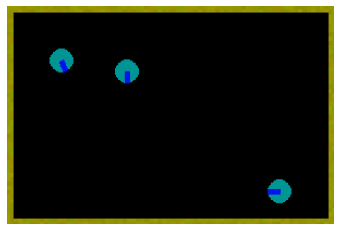

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Goal reached!


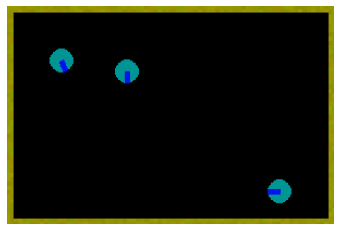

Done! reward= [0.9188518]


In [245]:
model = SAC.load("sac_moving6")
       
obs = env.reset()
n_steps = 2000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action)
#     print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        print("Done!", "reward=", reward)
        break

In [528]:
policy_kwargs = dict(n_critics=2, n_quantiles=25)
model = TQC("MlpPolicy", env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)
model.learn(total_timesteps=100000, log_interval=4)
model.save("tqc_DynamicObstacle_random")

Using cpu device
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 471      |
|    ep_rew_mean     | -490     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 33       |
|    time_elapsed    | 56       |
|    total_timesteps | 1884     |
| train/             |          |
|    actor_loss      | -4.59    |
|    critic_loss     | 0.0114   |
|    ent_coef        | 0.586    |
|    ent_coef_loss   | -2.68    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1783     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 288      |
|    ep_rew_mean     | -273     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32       |
|    time_elapsed    | 69       |
|    total_timesteps 

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 146      |
|    ep_rew_mean     | -82.9    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 31       |
|    time_elapsed    | 259      |
|    total_timesteps | 8195     |
| train/             |          |
|    actor_loss      | -5.29    |
|    critic_loss     | 0.0951   |
|    ent_coef        | 0.093    |
|    ent_coef_loss   | -9.49    |
|    learning_rate   | 0.0003   |
|    n_updates       | 8094     |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 143      |
|    ep_rew_mean     | -80.3    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 31       |
|    time_elapsed    | 272      |
|    total_timesteps | 8593     |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | -41.9    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 31       |
|    time_elapsed    | 405      |
|    total_timesteps | 12664    |
| train/             |          |
|    actor_loss      | 1.39     |
|    critic_loss     | 0.0941   |
|    ent_coef        | 0.0264   |
|    ent_coef_loss   | -11      |
|    learning_rate   | 0.0003   |
|    n_updates       | 12563    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 99       |
|    ep_rew_mean     | -39.8    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 31       |
|    time_elapsed    | 411      |
|    total_timesteps | 12816    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 83.3     |
|    ep_rew_mean     | -29.3    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 31       |
|    time_elapsed    | 545      |
|    total_timesteps | 16924    |
| train/             |          |
|    actor_loss      | 4.81     |
|    critic_loss     | 0.0445   |
|    ent_coef        | 0.0095   |
|    ent_coef_loss   | -4.67    |
|    learning_rate   | 0.0003   |
|    n_updates       | 16823    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81.8     |
|    ep_rew_mean     | -28.4    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 30       |
|    time_elapsed    | 555      |
|    total_timesteps | 17228    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 70.5     |
|    ep_rew_mean     | -22.8    |
| time/              |          |
|    episodes        | 212      |
|    fps             | 30       |
|    time_elapsed    | 644      |
|    total_timesteps | 19867    |
| train/             |          |
|    actor_loss      | 5.79     |
|    critic_loss     | 0.0456   |
|    ent_coef        | 0.00683  |
|    ent_coef_loss   | -1.65    |
|    learning_rate   | 0.0003   |
|    n_updates       | 19766    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 69.7     |
|    ep_rew_mean     | -22.5    |
| time/              |          |
|    episodes        | 216      |
|    fps             | 30       |
|    time_elapsed    | 649      |
|    total_timesteps | 20017    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 55       |
|    ep_rew_mean     | -18.3    |
| time/              |          |
|    episodes        | 264      |
|    fps             | 30       |
|    time_elapsed    | 740      |
|    total_timesteps | 22731    |
| train/             |          |
|    actor_loss      | 6.62     |
|    critic_loss     | 0.0499   |
|    ent_coef        | 0.00764  |
|    ent_coef_loss   | 0.886    |
|    learning_rate   | 0.0003   |
|    n_updates       | 22630    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 54.9     |
|    ep_rew_mean     | -18.4    |
| time/              |          |
|    episodes        | 268      |
|    fps             | 30       |
|    time_elapsed    | 749      |
|    total_timesteps | 22984    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 53.7     |
|    ep_rew_mean     | -17.6    |
| time/              |          |
|    episodes        | 316      |
|    fps             | 30       |
|    time_elapsed    | 830      |
|    total_timesteps | 25383    |
| train/             |          |
|    actor_loss      | 7.35     |
|    critic_loss     | 0.0569   |
|    ent_coef        | 0.00794  |
|    ent_coef_loss   | 0.302    |
|    learning_rate   | 0.0003   |
|    n_updates       | 25282    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51.7     |
|    ep_rew_mean     | -17.2    |
| time/              |          |
|    episodes        | 320      |
|    fps             | 30       |
|    time_elapsed    | 835      |
|    total_timesteps | 25503    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49.3     |
|    ep_rew_mean     | -16.4    |
| time/              |          |
|    episodes        | 368      |
|    fps             | 30       |
|    time_elapsed    | 915      |
|    total_timesteps | 27916    |
| train/             |          |
|    actor_loss      | 7.53     |
|    critic_loss     | 0.0656   |
|    ent_coef        | 0.00845  |
|    ent_coef_loss   | 2.08     |
|    learning_rate   | 0.0003   |
|    n_updates       | 27815    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 49       |
|    ep_rew_mean     | -16.4    |
| time/              |          |
|    episodes        | 372      |
|    fps             | 30       |
|    time_elapsed    | 920      |
|    total_timesteps | 28049    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.2     |
|    ep_rew_mean     | -16.5    |
| time/              |          |
|    episodes        | 420      |
|    fps             | 30       |
|    time_elapsed    | 997      |
|    total_timesteps | 30324    |
| train/             |          |
|    actor_loss      | 7.14     |
|    critic_loss     | 0.0726   |
|    ent_coef        | 0.00902  |
|    ent_coef_loss   | 0.574    |
|    learning_rate   | 0.0003   |
|    n_updates       | 30223    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.6     |
|    ep_rew_mean     | -16.5    |
| time/              |          |
|    episodes        | 424      |
|    fps             | 30       |
|    time_elapsed    | 1004     |
|    total_timesteps | 30528    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 46.3     |
|    ep_rew_mean     | -15.9    |
| time/              |          |
|    episodes        | 472      |
|    fps             | 30       |
|    time_elapsed    | 1077     |
|    total_timesteps | 32677    |
| train/             |          |
|    actor_loss      | 7.02     |
|    critic_loss     | 0.0694   |
|    ent_coef        | 0.00897  |
|    ent_coef_loss   | -1.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 32576    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47.1     |
|    ep_rew_mean     | -16.1    |
| time/              |          |
|    episodes        | 476      |
|    fps             | 30       |
|    time_elapsed    | 1085     |
|    total_timesteps | 32897    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.8     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 524      |
|    fps             | 30       |
|    time_elapsed    | 1154     |
|    total_timesteps | 34908    |
| train/             |          |
|    actor_loss      | 6.85     |
|    critic_loss     | 0.0866   |
|    ent_coef        | 0.00964  |
|    ent_coef_loss   | 1.38     |
|    learning_rate   | 0.0003   |
|    n_updates       | 34807    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43       |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 30       |
|    time_elapsed    | 1158     |
|    total_timesteps | 35016    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.2     |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 576      |
|    fps             | 30       |
|    time_elapsed    | 1233     |
|    total_timesteps | 37222    |
| train/             |          |
|    actor_loss      | 7.62     |
|    critic_loss     | 0.075    |
|    ent_coef        | 0.0098   |
|    ent_coef_loss   | -0.141   |
|    learning_rate   | 0.0003   |
|    n_updates       | 37121    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 43.7     |
|    ep_rew_mean     | -14.8    |
| time/              |          |
|    episodes        | 580      |
|    fps             | 30       |
|    time_elapsed    | 1238     |
|    total_timesteps | 37373    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 46       |
|    ep_rew_mean     | -15.4    |
| time/              |          |
|    episodes        | 628      |
|    fps             | 30       |
|    time_elapsed    | 1314     |
|    total_timesteps | 39617    |
| train/             |          |
|    actor_loss      | 7.02     |
|    critic_loss     | 0.0981   |
|    ent_coef        | 0.00969  |
|    ent_coef_loss   | -0.523   |
|    learning_rate   | 0.0003   |
|    n_updates       | 39516    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44.3     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 632      |
|    fps             | 30       |
|    time_elapsed    | 1318     |
|    total_timesteps | 39724    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47.3     |
|    ep_rew_mean     | -16.3    |
| time/              |          |
|    episodes        | 680      |
|    fps             | 30       |
|    time_elapsed    | 1400     |
|    total_timesteps | 42106    |
| train/             |          |
|    actor_loss      | 6.62     |
|    critic_loss     | 0.0906   |
|    ent_coef        | 0.00942  |
|    ent_coef_loss   | -0.508   |
|    learning_rate   | 0.0003   |
|    n_updates       | 42005    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47.6     |
|    ep_rew_mean     | -16.5    |
| time/              |          |
|    episodes        | 684      |
|    fps             | 30       |
|    time_elapsed    | 1408     |
|    total_timesteps | 42362    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 44       |
|    ep_rew_mean     | -15.6    |
| time/              |          |
|    episodes        | 732      |
|    fps             | 30       |
|    time_elapsed    | 1469     |
|    total_timesteps | 44124    |
| train/             |          |
|    actor_loss      | 6.56     |
|    critic_loss     | 0.0866   |
|    ent_coef        | 0.0096   |
|    ent_coef_loss   | 0.343    |
|    learning_rate   | 0.0003   |
|    n_updates       | 44023    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.4     |
|    ep_rew_mean     | -15.2    |
| time/              |          |
|    episodes        | 736      |
|    fps             | 30       |
|    time_elapsed    | 1473     |
|    total_timesteps | 44254    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36       |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 784      |
|    fps             | 29       |
|    time_elapsed    | 1532     |
|    total_timesteps | 45962    |
| train/             |          |
|    actor_loss      | 6.28     |
|    critic_loss     | 0.0998   |
|    ent_coef        | 0.0101   |
|    ent_coef_loss   | -0.511   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45861    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 788      |
|    fps             | 29       |
|    time_elapsed    | 1537     |
|    total_timesteps | 46076    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.7     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 836      |
|    fps             | 29       |
|    time_elapsed    | 1613     |
|    total_timesteps | 48325    |
| train/             |          |
|    actor_loss      | 6.97     |
|    critic_loss     | 0.095    |
|    ent_coef        | 0.00994  |
|    ent_coef_loss   | -0.235   |
|    learning_rate   | 0.0003   |
|    n_updates       | 48224    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.4     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 840      |
|    fps             | 29       |
|    time_elapsed    | 1617     |
|    total_timesteps | 48431    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42       |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 888      |
|    fps             | 29       |
|    time_elapsed    | 1680     |
|    total_timesteps | 50279    |
| train/             |          |
|    actor_loss      | 6.86     |
|    critic_loss     | 0.0911   |
|    ent_coef        | 0.0102   |
|    ent_coef_loss   | 0.824    |
|    learning_rate   | 0.0003   |
|    n_updates       | 50178    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41       |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 892      |
|    fps             | 29       |
|    time_elapsed    | 1685     |
|    total_timesteps | 50410    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.7     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 940      |
|    fps             | 29       |
|    time_elapsed    | 1747     |
|    total_timesteps | 52201    |
| train/             |          |
|    actor_loss      | 6.62     |
|    critic_loss     | 0.0893   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.782    |
|    learning_rate   | 0.0003   |
|    n_updates       | 52100    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.9     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 944      |
|    fps             | 29       |
|    time_elapsed    | 1751     |
|    total_timesteps | 52329    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.5     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 992      |
|    fps             | 29       |
|    time_elapsed    | 1819     |
|    total_timesteps | 54258    |
| train/             |          |
|    actor_loss      | 6.34     |
|    critic_loss     | 0.103    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.0348   |
|    learning_rate   | 0.0003   |
|    n_updates       | 54157    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.3     |
|    ep_rew_mean     | -13.5    |
| time/              |          |
|    episodes        | 996      |
|    fps             | 29       |
|    time_elapsed    | 1823     |
|    total_timesteps | 54376    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38       |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 1044     |
|    fps             | 29       |
|    time_elapsed    | 1887     |
|    total_timesteps | 56132    |
| train/             |          |
|    actor_loss      | 6.18     |
|    critic_loss     | 0.0906   |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | -0.886   |
|    learning_rate   | 0.0003   |
|    n_updates       | 56031    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.3     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 1048     |
|    fps             | 29       |
|    time_elapsed    | 1892     |
|    total_timesteps | 56271    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.3     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1096     |
|    fps             | 29       |
|    time_elapsed    | 1954     |
|    total_timesteps | 58008    |
| train/             |          |
|    actor_loss      | 6.23     |
|    critic_loss     | 0.0874   |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | 0.299    |
|    learning_rate   | 0.0003   |
|    n_updates       | 57907    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.9     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 1100     |
|    fps             | 29       |
|    time_elapsed    | 1961     |
|    total_timesteps | 58196    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.8     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 1148     |
|    fps             | 29       |
|    time_elapsed    | 2031     |
|    total_timesteps | 60151    |
| train/             |          |
|    actor_loss      | 6.67     |
|    critic_loss     | 0.0759   |
|    ent_coef        | 0.0109   |
|    ent_coef_loss   | 2.48     |
|    learning_rate   | 0.0003   |
|    n_updates       | 60050    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.9     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 1152     |
|    fps             | 29       |
|    time_elapsed    | 2040     |
|    total_timesteps | 60397    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | -14      |
| time/              |          |
|    episodes        | 1200     |
|    fps             | 29       |
|    time_elapsed    | 2105     |
|    total_timesteps | 62193    |
| train/             |          |
|    actor_loss      | 5.65     |
|    critic_loss     | 0.0754   |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | 1.14     |
|    learning_rate   | 0.0003   |
|    n_updates       | 62092    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.2     |
|    ep_rew_mean     | -14.1    |
| time/              |          |
|    episodes        | 1204     |
|    fps             | 29       |
|    time_elapsed    | 2111     |
|    total_timesteps | 62357    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.8     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 1252     |
|    fps             | 29       |
|    time_elapsed    | 2179     |
|    total_timesteps | 64174    |
| train/             |          |
|    actor_loss      | 5.22     |
|    critic_loss     | 0.0916   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.209    |
|    learning_rate   | 0.0003   |
|    n_updates       | 64073    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.7     |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    episodes        | 1256     |
|    fps             | 29       |
|    time_elapsed    | 2184     |
|    total_timesteps | 64297    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.7     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1304     |
|    fps             | 29       |
|    time_elapsed    | 2247     |
|    total_timesteps | 66025    |
| train/             |          |
|    actor_loss      | 5.67     |
|    critic_loss     | 0.0811   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.761    |
|    learning_rate   | 0.0003   |
|    n_updates       | 65924    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.9     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1308     |
|    fps             | 29       |
|    time_elapsed    | 2253     |
|    total_timesteps | 66182    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 1356     |
|    fps             | 29       |
|    time_elapsed    | 2313     |
|    total_timesteps | 67830    |
| train/             |          |
|    actor_loss      | 5.83     |
|    critic_loss     | 0.0758   |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | -1.12    |
|    learning_rate   | 0.0003   |
|    n_updates       | 67729    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1360     |
|    fps             | 29       |
|    time_elapsed    | 2317     |
|    total_timesteps | 67947    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1408     |
|    fps             | 29       |
|    time_elapsed    | 2382     |
|    total_timesteps | 69719    |
| train/             |          |
|    actor_loss      | 6.14     |
|    critic_loss     | 0.0721   |
|    ent_coef        | 0.0102   |
|    ent_coef_loss   | 0.293    |
|    learning_rate   | 0.0003   |
|    n_updates       | 69618    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.1     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1412     |
|    fps             | 29       |
|    time_elapsed    | 2386     |
|    total_timesteps | 69829    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36       |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 1460     |
|    fps             | 29       |
|    time_elapsed    | 2449     |
|    total_timesteps | 71547    |
| train/             |          |
|    actor_loss      | 5.06     |
|    critic_loss     | 0.0817   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.17     |
|    learning_rate   | 0.0003   |
|    n_updates       | 71446    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.6     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1464     |
|    fps             | 29       |
|    time_elapsed    | 2454     |
|    total_timesteps | 71688    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1512     |
|    fps             | 29       |
|    time_elapsed    | 2515     |
|    total_timesteps | 73303    |
| train/             |          |
|    actor_loss      | 5.92     |
|    critic_loss     | 0.0626   |
|    ent_coef        | 0.0108   |
|    ent_coef_loss   | 0.853    |
|    learning_rate   | 0.0003   |
|    n_updates       | 73202    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1516     |
|    fps             | 29       |
|    time_elapsed    | 2520     |
|    total_timesteps | 73434    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 1564     |
|    fps             | 29       |
|    time_elapsed    | 2583     |
|    total_timesteps | 75161    |
| train/             |          |
|    actor_loss      | 5.86     |
|    critic_loss     | 0.0691   |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | 1.16     |
|    learning_rate   | 0.0003   |
|    n_updates       | 75060    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.5     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1568     |
|    fps             | 29       |
|    time_elapsed    | 2587     |
|    total_timesteps | 75290    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.7     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1616     |
|    fps             | 29       |
|    time_elapsed    | 2649     |
|    total_timesteps | 77006    |
| train/             |          |
|    actor_loss      | 5.86     |
|    critic_loss     | 0.0853   |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | -0.523   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76905    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 1620     |
|    fps             | 29       |
|    time_elapsed    | 2653     |
|    total_timesteps | 77111    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1668     |
|    fps             | 29       |
|    time_elapsed    | 2714     |
|    total_timesteps | 78764    |
| train/             |          |
|    actor_loss      | 5.7      |
|    critic_loss     | 0.0602   |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | -0.24    |
|    learning_rate   | 0.0003   |
|    n_updates       | 78663    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1672     |
|    fps             | 29       |
|    time_elapsed    | 2720     |
|    total_timesteps | 78939    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.3     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1720     |
|    fps             | 28       |
|    time_elapsed    | 2779     |
|    total_timesteps | 80545    |
| train/             |          |
|    actor_loss      | 5.39     |
|    critic_loss     | 0.0635   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.292    |
|    learning_rate   | 0.0003   |
|    n_updates       | 80444    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1724     |
|    fps             | 28       |
|    time_elapsed    | 2782     |
|    total_timesteps | 80646    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.5     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1772     |
|    fps             | 28       |
|    time_elapsed    | 2840     |
|    total_timesteps | 82286    |
| train/             |          |
|    actor_loss      | 5.73     |
|    critic_loss     | 0.0678   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.364    |
|    learning_rate   | 0.0003   |
|    n_updates       | 82185    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.4     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1776     |
|    fps             | 28       |
|    time_elapsed    | 2845     |
|    total_timesteps | 82409    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.3     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1824     |
|    fps             | 28       |
|    time_elapsed    | 2905     |
|    total_timesteps | 84074    |
| train/             |          |
|    actor_loss      | 5.24     |
|    critic_loss     | 0.0675   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.387    |
|    learning_rate   | 0.0003   |
|    n_updates       | 83973    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34       |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1828     |
|    fps             | 28       |
|    time_elapsed    | 2909     |
|    total_timesteps | 84206    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1876     |
|    fps             | 28       |
|    time_elapsed    | 2974     |
|    total_timesteps | 86046    |
| train/             |          |
|    actor_loss      | 5.35     |
|    critic_loss     | 0.0666   |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | 0.834    |
|    learning_rate   | 0.0003   |
|    n_updates       | 85945    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.7     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 1880     |
|    fps             | 28       |
|    time_elapsed    | 2979     |
|    total_timesteps | 86195    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.6     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1928     |
|    fps             | 28       |
|    time_elapsed    | 3039     |
|    total_timesteps | 87868    |
| train/             |          |
|    actor_loss      | 5.02     |
|    critic_loss     | 0.0652   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.464    |
|    learning_rate   | 0.0003   |
|    n_updates       | 87767    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.9     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1932     |
|    fps             | 28       |
|    time_elapsed    | 3043     |
|    total_timesteps | 87977    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.8     |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 1980     |
|    fps             | 28       |
|    time_elapsed    | 3110     |
|    total_timesteps | 89871    |
| train/             |          |
|    actor_loss      | 5.11     |
|    critic_loss     | 0.0605   |
|    ent_coef        | 0.0102   |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 89770    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.1     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 1984     |
|    fps             | 28       |
|    time_elapsed    | 3115     |
|    total_timesteps | 90026    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.3     |
|    ep_rew_mean     | -13.2    |
| time/              |          |
|    episodes        | 2032     |
|    fps             | 28       |
|    time_elapsed    | 3175     |
|    total_timesteps | 91709    |
| train/             |          |
|    actor_loss      | 5.09     |
|    critic_loss     | 0.0675   |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | 0.0599   |
|    learning_rate   | 0.0003   |
|    n_updates       | 91608    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37       |
|    ep_rew_mean     | -13      |
| time/              |          |
|    episodes        | 2036     |
|    fps             | 28       |
|    time_elapsed    | 3180     |
|    total_timesteps | 91840    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.5     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 2084     |
|    fps             | 28       |
|    time_elapsed    | 3246     |
|    total_timesteps | 93675    |
| train/             |          |
|    actor_loss      | 4.84     |
|    critic_loss     | 0.0595   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | -0.322   |
|    learning_rate   | 0.0003   |
|    n_updates       | 93574    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.8     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 2088     |
|    fps             | 28       |
|    time_elapsed    | 3253     |
|    total_timesteps | 93876    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.3     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 2136     |
|    fps             | 28       |
|    time_elapsed    | 3322     |
|    total_timesteps | 95871    |
| train/             |          |
|    actor_loss      | 5.52     |
|    critic_loss     | 0.0585   |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 1.32     |
|    learning_rate   | 0.0003   |
|    n_updates       | 95770    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.2     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 2140     |
|    fps             | 28       |
|    time_elapsed    | 3328     |
|    total_timesteps | 96015    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.7     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 2188     |
|    fps             | 28       |
|    time_elapsed    | 3394     |
|    total_timesteps | 97850    |
| train/             |          |
|    actor_loss      | 5.29     |
|    critic_loss     | 0.0634   |
|    ent_coef        | 0.0101   |
|    ent_coef_loss   | -0.346   |
|    learning_rate   | 0.0003   |
|    n_updates       | 97749    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.3     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 2192     |
|    fps             | 28       |
|    time_elapsed    | 3400     |
|    total_timesteps | 98031    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.1     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 2240     |
|    fps             | 28       |
|    time_elapsed    | 3462     |
|    total_timesteps | 99726    |
| train/             |          |
|    actor_loss      | 5.79     |
|    critic_loss     | 0.0615   |
|    ent_coef        | 0.0101   |
|    ent_coef_loss   | -1.04    |
|    learning_rate   | 0.0003   |
|    n_updates       | 99625    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37       |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 2244     |
|    fps             | 28       |
|    time_elapsed    | 3467     |
|    total_timesteps | 99870    |
| tr

In [126]:
model = TQC.load("tqc_DynamicObstacle")
        
obs = env.reset()
n_steps = 2000

for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
#     print("Action: ", action)
    obs, reward, done, info = env.step(action)
#     print('obs=', obs, 'reward=', reward, 'done=', done)
    env.render(mode='console')
    if done:
        print("Done!", "reward=", reward)
        break

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Goal reached!
Done! reward= [0.9280265]


## Evaluation & Comparison
Two criteria: Number of steps per eposide & Number of collisions per episode.  
Here we test 50 episodes on the trained models

In [545]:
def evaluate(model, num_episode):
    num_steps = []
    num_collisions = []
    for i in range(num_episode):
        obs = env.reset()
        n_steps = 200
        collision = 0
        for step in range(n_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            dist = obs[0][1]
            if reward + dist == -0.5:
                collision += 1
            env.render(mode='console')
            if done:
                print("Done!", "reward=", reward)
                break
        num_steps.append(step)
        num_collisions.append(collision)
    return num_steps, num_collisions

In [727]:
model = PPO.load("PPO_moving_18_randomstart")
# model = TQC.load("tqc_DynamicObstacle_random")
# model = SAC.load("sac_moving6_random")
# model = A2C.load("a2c_moving6_random")
steps_PPO, collisions_PPO = evaluate(model, 50)

Goal reached!
Done! reward= [0.9017382]
Goal reached!
Done! reward= [0.90177625]
Goal reached!
Done! reward= [0.90872663]
Goal reached!
Done! reward= [0.9071115]
Goal reached!
Done! reward= [0.9208548]
Goal reached!
Done! reward= [0.90394694]
Goal reached!
Done! reward= [0.910028]
Goal reached!
Done! reward= [0.91452485]
Goal reached!
Done! reward= [0.91024333]
Goal reached!
Done! reward= [0.9122865]
Goal reached!
Done! reward= [0.9119404]
Goal reached!
Done! reward= [0.9115178]
Goal reached!
Done! reward= [0.9219957]
Goal reached!
Done! reward= [0.9034943]
Goal reached!
Done! reward= [0.9005796]
Goal reached!
Done! reward= [0.90724736]
Goal reached!
Done! reward= [0.9042789]
Goal reached!
Done! reward= [0.91383535]
Goal reached!
Done! reward= [0.9097754]
Goal reached!
Done! reward= [0.9053941]
Goal reached!
Done! reward= [0.9068978]
Goal reached!
Done! reward= [0.90205127]
Goal reached!
Done! reward= [0.9081588]
Goal reached!
Done! reward= [0.9003388]
Goal reached!
Done! reward= [0.91

In [728]:
# Compare the mean reward per episode, mean number of collisions per episode, mean number of steps per episode
print ("SAC mean steps per episode",np.mean(steps_SAC))
print ("A2C mean steps per episode",np.mean(steps_A2C))
print ("PPO mean steps per episode",np.mean(steps_PPO))
print ("TQC mean steps per episode",np.mean(steps_TQC))
print("SAC mean collisions per episode", np.mean(collisions_SAC))
print ("A2C mean collisions per episode",np.mean(collisions_A2C))
print ("PPO mean collisions per episode",np.mean(collisions_PPO))
print ("TQC mean collisions per episode",np.mean(collisions_TQC))

SAC mean steps per episode 30.66
A2C mean steps per episode 183.6
PPO mean steps per episode 58.82
TQC mean steps per episode 35.04
SAC mean collisions per episode 0.02
A2C mean collisions per episode 2.48
PPO mean collisions per episode 0.14
TQC mean collisions per episode 0.0


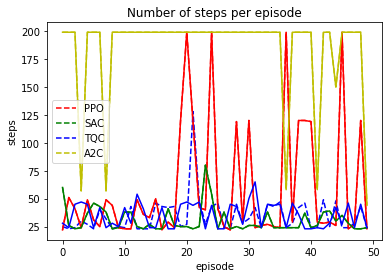

In [729]:
import numpy as np
import matplotlib.pyplot as plt  
x = list(range(0, 50))

l1=plt.plot(x,steps_PPO,'r--',label='PPO')
l2=plt.plot(x,steps_SAC,'g--',label='SAC')
l3=plt.plot(x,steps_tqc,'b--',label='TQC')
l4=plt.plot(x,steps_A2C,'y--',label='A2C')
plt.plot(x,steps_PPO,'r',x,steps_SAC,'g',x,steps_TQC,'b',x, steps_A2C,'y' )
plt.title('Number of steps per episode')
plt.xlabel('episode')
plt.ylabel('steps')
plt.legend()
# plt.show()
plt.savefig('steps_performance.png')

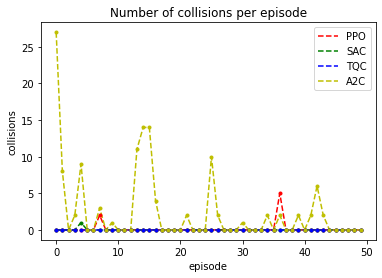

In [730]:
x = list(range(0, 50))
l1=plt.plot(x,collisions_PPO,'r--',label='PPO')
l2=plt.plot(x,collisions_SAC,'g--',label='SAC')
l3=plt.plot(x,collisions_tqc,'b--',label='TQC')
l4=plt.plot(x,collisions_A2C,'y--',label='A2C')
plt.plot(x,collisions_PPO,'r.', x,collisions_SAC,'g.',x,collisions_TQC, 'b.',x, collisions_A2C, 'y.' )
plt.title('Number of collisions per episode')
plt.xlabel('episode')
plt.ylabel('collisions')
plt.legend()
# plt.show()
plt.savefig('collisions_performance.png')

## Plot the Learning Curve

In [679]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [680]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), 'timesteps')
            if len(x) > 0:
              # Mean training reward over the last 100 episodes
                  mean_reward = np.mean(y[-100:])
                  if self.verbose > 0:
                        print(f"Num timesteps: {self.num_timesteps}")
                        print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              
            if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                  # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [681]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = myEnv(my_playground)
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [682]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = SAC("MlpPolicy", env, verbose=1)
# model = A2C("MlpPolicy", env, verbose=1)
# policy_kwargs = dict(n_critics=2, n_quantiles=25)
# model = TQC("MlpPolicy", env, top_quantiles_to_drop_per_net=2, verbose=1, policy_kwargs=policy_kwargs)
# Train the agent
model.learn(total_timesteps=100000, callback=callback, log_interval=4)

Using cpu device
Wrapping the env in a DummyVecEnv.
Goal reached!
Goal reached!
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -453.93
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 342      |
|    ep_rew_mean     | -301     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 49       |
|    time_elapsed    | 27       |
|    total_timesteps | 1370     |
| train/             |          |
|    actor_loss      | -5.53    |
|    critic_loss     | 0.277    |
|    ent_coef        | 0.684    |
|    ent_coef_loss   | -1.92    |
|    learning_rate   | 0.0003   |
|    n_updates       | 1269     |
---------------------------------
Goal reached!
Num timesteps: 2000
Best mean reward: -453.93 - Last mean reward per episode: -302.20
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
Goal 

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 188      |
|    ep_rew_mean     | -93.6    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 45       |
|    time_elapsed    | 212      |
|    total_timesteps | 9765     |
| train/             |          |
|    actor_loss      | -1.18    |
|    critic_loss     | 0.189    |
|    ent_coef        | 0.0599   |
|    ent_coef_loss   | -10.5    |
|    learning_rate   | 0.0003   |
|    n_updates       | 9664     |
---------------------------------
Goal reached!
Goal reached!
Num timesteps: 10000
Best mean reward: -94.65 - Last mean reward per episode: -90.72
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 181      |
|    ep_rew_mean     | -88.8    |
| time/              |          |
|    e

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 153      |
|    ep_rew_mean     | -66.2    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 45       |
|    time_elapsed    | 335      |
|    total_timesteps | 15270    |
| train/             |          |
|    actor_loss      | 5.3      |
|    critic_loss     | 0.133    |
|    ent_coef        | 0.0138   |
|    ent_coef_loss   | -6.07    |
|    learning_rate   | 0.0003   |
|    n_updates       | 15169    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 142      |
|    ep_rew_mean     | -55.1    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 45       |
|    time_elapsed    | 341      |
|    total_timesteps | 15529    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.1     |
|    ep_rew_mean     | -29.7    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 45       |
|    time_elapsed    | 421      |
|    total_timesteps | 18971    |
| train/             |          |
|    actor_loss      | 7.11     |
|    critic_loss     | 0.154    |
|    ent_coef        | 0.00853  |
|    ent_coef_loss   | -1.29    |
|    learning_rate   | 0.0003   |
|    n_updates       | 18870    |
---------------------------------
Num timesteps: 19000
Best mean reward: -37.58 - Last mean reward per episode: -29.70
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 90.2     |
|    ep_rew_mean     | -29.2    |
| time/              |          |
|    e

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 57.9     |
|    ep_rew_mean     | -19.2    |
| time/              |          |
|    episodes        | 204      |
|    fps             | 44       |
|    time_elapsed    | 478      |
|    total_timesteps | 21317    |
| train/             |          |
|    actor_loss      | 6.93     |
|    critic_loss     | 0.209    |
|    ent_coef        | 0.00932  |
|    ent_coef_loss   | -0.998   |
|    learning_rate   | 0.0003   |
|    n_updates       | 21216    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 57.5     |
|    ep_rew_mean     | -18.8    |
| time/              |          |
|    episodes        | 208      |
|    fps             | 44       |
|    time_elapsed    | 484      |
|    total_timesteps | 21584    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48.2     |
|    ep_rew_mean     | -16.6    |
| time/              |          |
|    episodes        | 256      |
|    fps             | 44       |
|    time_elapsed    | 540      |
|    total_timesteps | 23952    |
| train/             |          |
|    actor_loss      | 7.91     |
|    critic_loss     | 0.174    |
|    ent_coef        | 0.0108   |
|    ent_coef_loss   | 0.951    |
|    learning_rate   | 0.0003   |
|    n_updates       | 23851    |
---------------------------------
Num timesteps: 24000
Best mean reward: -17.07 - Last mean reward per episode: -16.58
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50.2     |
|    ep_rew_mean     | -17.1    |
| time/              |          |
|    e

Goal reached!
Goal reached!
Num timesteps: 27000
Best mean reward: -16.58 - Last mean reward per episode: -18.55
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 55.6     |
|    ep_rew_mean     | -19      |
| time/              |          |
|    episodes        | 308      |
|    fps             | 44       |
|    time_elapsed    | 613      |
|    total_timesteps | 27145    |
| train/             |          |
|    actor_loss      | 7.89     |
|    critic_loss     | 0.224    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | -0.659   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27044    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 55.5     |
|    ep_rew_mean     | -19.1    |
| time/              |          |
|    episodes        | 312      |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 52.3     |
|    ep_rew_mean     | -17.9    |
| time/              |          |
|    episodes        | 360      |
|    fps             | 44       |
|    time_elapsed    | 670      |
|    total_timesteps | 29543    |
| train/             |          |
|    actor_loss      | 7.77     |
|    critic_loss     | 0.256    |
|    ent_coef        | 0.011    |
|    ent_coef_loss   | -0.0215  |
|    learning_rate   | 0.0003   |
|    n_updates       | 29442    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50.8     |
|    ep_rew_mean     | -17.6    |
| time/              |          |
|    episodes        | 364      |
|    fps             | 44       |
|    time_elapsed    | 674      |
|    total_timesteps | 29700    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.7     |
|    ep_rew_mean     | -15.1    |
| time/              |          |
|    episodes        | 412      |
|    fps             | 43       |
|    time_elapsed    | 719      |
|    total_timesteps | 31564    |
| train/             |          |
|    actor_loss      | 7.72     |
|    critic_loss     | 0.243    |
|    ent_coef        | 0.0121   |
|    ent_coef_loss   | -0.49    |
|    learning_rate   | 0.0003   |
|    n_updates       | 31463    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.6     |
|    ep_rew_mean     | -15      |
| time/              |          |
|    episodes        | 416      |
|    fps             | 43       |
|    time_elapsed    | 723      |
|    total_timesteps | 31708    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.7     |
|    ep_rew_mean     | -14.1    |
| time/              |          |
|    episodes        | 464      |
|    fps             | 43       |
|    time_elapsed    | 766      |
|    total_timesteps | 33474    |
| train/             |          |
|    actor_loss      | 7.15     |
|    critic_loss     | 0.329    |
|    ent_coef        | 0.012    |
|    ent_coef_loss   | -1.45    |
|    learning_rate   | 0.0003   |
|    n_updates       | 33373    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.2     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 468      |
|    fps             | 43       |
|    time_elapsed    | 770      |
|    total_timesteps | 33668    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.8     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 516      |
|    fps             | 43       |
|    time_elapsed    | 821      |
|    total_timesteps | 35783    |
| train/             |          |
|    actor_loss      | 7.32     |
|    critic_loss     | 0.215    |
|    ent_coef        | 0.0121   |
|    ent_coef_loss   | -1.61    |
|    learning_rate   | 0.0003   |
|    n_updates       | 35682    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.7     |
|    ep_rew_mean     | -14.6    |
| time/              |          |
|    episodes        | 520      |
|    fps             | 43       |
|    time_elapsed    | 824      |
|    total_timesteps | 35918    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.9     |
|    ep_rew_mean     | -14.3    |
| time/              |          |
|    episodes        | 568      |
|    fps             | 43       |
|    time_elapsed    | 866      |
|    total_timesteps | 37654    |
| train/             |          |
|    actor_loss      | 6.58     |
|    critic_loss     | 0.243    |
|    ent_coef        | 0.0119   |
|    ent_coef_loss   | 0.141    |
|    learning_rate   | 0.0003   |
|    n_updates       | 37553    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 39.5     |
|    ep_rew_mean     | -14.2    |
| time/              |          |
|    episodes        | 572      |
|    fps             | 43       |
|    time_elapsed    | 869      |
|    total_timesteps | 37781    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.4     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 620      |
|    fps             | 43       |
|    time_elapsed    | 915      |
|    total_timesteps | 39660    |
| train/             |          |
|    actor_loss      | 6.2      |
|    critic_loss     | 0.224    |
|    ent_coef        | 0.012    |
|    ent_coef_loss   | -0.377   |
|    learning_rate   | 0.0003   |
|    n_updates       | 39559    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.5     |
|    ep_rew_mean     | -13.8    |
| time/              |          |
|    episodes        | 624      |
|    fps             | 43       |
|    time_elapsed    | 919      |
|    total_timesteps | 39803    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.5     |
|    ep_rew_mean     | -13.7    |
| time/              |          |
|    episodes        | 672      |
|    fps             | 43       |
|    time_elapsed    | 963      |
|    total_timesteps | 41627    |
| train/             |          |
|    actor_loss      | 5.73     |
|    critic_loss     | 0.196    |
|    ent_coef        | 0.0117   |
|    ent_coef_loss   | -0.0257  |
|    learning_rate   | 0.0003   |
|    n_updates       | 41526    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.1     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 676      |
|    fps             | 43       |
|    time_elapsed    | 966      |
|    total_timesteps | 41746    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.7     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 724      |
|    fps             | 43       |
|    time_elapsed    | 1008     |
|    total_timesteps | 43473    |
| train/             |          |
|    actor_loss      | 5.85     |
|    critic_loss     | 0.143    |
|    ent_coef        | 0.0115   |
|    ent_coef_loss   | -1.33    |
|    learning_rate   | 0.0003   |
|    n_updates       | 43372    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.6     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 728      |
|    fps             | 43       |
|    time_elapsed    | 1011     |
|    total_timesteps | 43585    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.9     |
|    ep_rew_mean     | -13.4    |
| time/              |          |
|    episodes        | 776      |
|    fps             | 42       |
|    time_elapsed    | 1058     |
|    total_timesteps | 45536    |
| train/             |          |
|    actor_loss      | 5.8      |
|    critic_loss     | 0.161    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -0.543   |
|    learning_rate   | 0.0003   |
|    n_updates       | 45435    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.7     |
|    ep_rew_mean     | -13.6    |
| time/              |          |
|    episodes        | 780      |
|    fps             | 42       |
|    time_elapsed    | 1063     |
|    total_timesteps | 45717    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.2     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 828      |
|    fps             | 42       |
|    time_elapsed    | 1102     |
|    total_timesteps | 47302    |
| train/             |          |
|    actor_loss      | 7.15     |
|    critic_loss     | 0.183    |
|    ent_coef        | 0.0111   |
|    ent_coef_loss   | 2.32     |
|    learning_rate   | 0.0003   |
|    n_updates       | 47201    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.9     |
|    ep_rew_mean     | -13.1    |
| time/              |          |
|    episodes        | 832      |
|    fps             | 42       |
|    time_elapsed    | 1107     |
|    total_timesteps | 47500    |
| tr

Num timesteps: 49000
Best mean reward: -12.70 - Last mean reward per episode: -12.47
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 880      |
|    fps             | 42       |
|    time_elapsed    | 1148     |
|    total_timesteps | 49187    |
| train/             |          |
|    actor_loss      | 6.2      |
|    critic_loss     | 0.155    |
|    ent_coef        | 0.0114   |
|    ent_coef_loss   | 0.113    |
|    learning_rate   | 0.0003   |
|    n_updates       | 49086    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.5     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    e

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.6     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 932      |
|    fps             | 42       |
|    time_elapsed    | 1190     |
|    total_timesteps | 50863    |
| train/             |          |
|    actor_loss      | 6.09     |
|    critic_loss     | 0.184    |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | -0.598   |
|    learning_rate   | 0.0003   |
|    n_updates       | 50762    |
---------------------------------
Goal reached!
Goal reached!
Num timesteps: 51000
Best mean reward: -12.47 - Last mean reward per episode: -12.38
Saving new best model to /tmp/gym/best_model.zip
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.2     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    e

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32.1     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 984      |
|    fps             | 42       |
|    time_elapsed    | 1231     |
|    total_timesteps | 52508    |
| train/             |          |
|    actor_loss      | 5.56     |
|    critic_loss     | 0.136    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -2.18    |
|    learning_rate   | 0.0003   |
|    n_updates       | 52407    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.9     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 988      |
|    fps             | 42       |
|    time_elapsed    | 1235     |
|    total_timesteps | 52653    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.8     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1036     |
|    fps             | 42       |
|    time_elapsed    | 1281     |
|    total_timesteps | 54517    |
| train/             |          |
|    actor_loss      | 5.05     |
|    critic_loss     | 0.151    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | -1.67    |
|    learning_rate   | 0.0003   |
|    n_updates       | 54416    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.8     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1040     |
|    fps             | 42       |
|    time_elapsed    | 1284     |
|    total_timesteps | 54648    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.2     |
|    ep_rew_mean     | -12.9    |
| time/              |          |
|    episodes        | 1088     |
|    fps             | 42       |
|    time_elapsed    | 1324     |
|    total_timesteps | 56270    |
| train/             |          |
|    actor_loss      | 5.74     |
|    critic_loss     | 0.167    |
|    ent_coef        | 0.0111   |
|    ent_coef_loss   | -0.158   |
|    learning_rate   | 0.0003   |
|    n_updates       | 56169    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.7     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1092     |
|    fps             | 42       |
|    time_elapsed    | 1327     |
|    total_timesteps | 56387    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.2     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1140     |
|    fps             | 42       |
|    time_elapsed    | 1371     |
|    total_timesteps | 58172    |
| train/             |          |
|    actor_loss      | 5.64     |
|    critic_loss     | 0.2      |
|    ent_coef        | 0.011    |
|    ent_coef_loss   | 1.04     |
|    learning_rate   | 0.0003   |
|    n_updates       | 58071    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1144     |
|    fps             | 42       |
|    time_elapsed    | 1373     |
|    total_timesteps | 58275    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1192     |
|    fps             | 42       |
|    time_elapsed    | 1414     |
|    total_timesteps | 59921    |
| train/             |          |
|    actor_loss      | 5.5      |
|    critic_loss     | 0.148    |
|    ent_coef        | 0.011    |
|    ent_coef_loss   | 1.61     |
|    learning_rate   | 0.0003   |
|    n_updates       | 59820    |
---------------------------------
Goal reached!
Goal reached!
Num timesteps: 60000
Best mean reward: -12.28 - Last mean reward per episode: -12.54
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1196     |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.2     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 1244     |
|    fps             | 42       |
|    time_elapsed    | 1458     |
|    total_timesteps | 61693    |
| train/             |          |
|    actor_loss      | 4.82     |
|    critic_loss     | 0.168    |
|    ent_coef        | 0.0108   |
|    ent_coef_loss   | -0.0108  |
|    learning_rate   | 0.0003   |
|    n_updates       | 61592    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.5     |
|    ep_rew_mean     | -12      |
| time/              |          |
|    episodes        | 1248     |
|    fps             | 42       |
|    time_elapsed    | 1462     |
|    total_timesteps | 61821    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.6     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1296     |
|    fps             | 42       |
|    time_elapsed    | 1504     |
|    total_timesteps | 63507    |
| train/             |          |
|    actor_loss      | 5.03     |
|    critic_loss     | 0.155    |
|    ent_coef        | 0.011    |
|    ent_coef_loss   | -0.748   |
|    learning_rate   | 0.0003   |
|    n_updates       | 63406    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.5     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 1300     |
|    fps             | 42       |
|    time_elapsed    | 1508     |
|    total_timesteps | 63673    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.8     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1348     |
|    fps             | 42       |
|    time_elapsed    | 1551     |
|    total_timesteps | 65403    |
| train/             |          |
|    actor_loss      | 4.85     |
|    critic_loss     | 0.151    |
|    ent_coef        | 0.0113   |
|    ent_coef_loss   | 0.454    |
|    learning_rate   | 0.0003   |
|    n_updates       | 65302    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.3     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1352     |
|    fps             | 42       |
|    time_elapsed    | 1555     |
|    total_timesteps | 65535    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.5     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1400     |
|    fps             | 42       |
|    time_elapsed    | 1601     |
|    total_timesteps | 67418    |
| train/             |          |
|    actor_loss      | 5.26     |
|    critic_loss     | 0.161    |
|    ent_coef        | 0.0112   |
|    ent_coef_loss   | -2.39    |
|    learning_rate   | 0.0003   |
|    n_updates       | 67317    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37       |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1404     |
|    fps             | 42       |
|    time_elapsed    | 1604     |
|    total_timesteps | 67569    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.2     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1452     |
|    fps             | 42       |
|    time_elapsed    | 1647     |
|    total_timesteps | 69251    |
| train/             |          |
|    actor_loss      | 5.06     |
|    critic_loss     | 0.116    |
|    ent_coef        | 0.0108   |
|    ent_coef_loss   | -0.012   |
|    learning_rate   | 0.0003   |
|    n_updates       | 69150    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.5     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1456     |
|    fps             | 42       |
|    time_elapsed    | 1651     |
|    total_timesteps | 69411    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.7     |
|    ep_rew_mean     | -12.5    |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 41       |
|    time_elapsed    | 1694     |
|    total_timesteps | 71139    |
| train/             |          |
|    actor_loss      | 5.04     |
|    critic_loss     | 0.233    |
|    ent_coef        | 0.0106   |
|    ent_coef_loss   | -0.353   |
|    learning_rate   | 0.0003   |
|    n_updates       | 71038    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.6     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1508     |
|    fps             | 41       |
|    time_elapsed    | 1700     |
|    total_timesteps | 71371    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.8     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1556     |
|    fps             | 41       |
|    time_elapsed    | 1741     |
|    total_timesteps | 72991    |
| train/             |          |
|    actor_loss      | 5.5      |
|    critic_loss     | 0.171    |
|    ent_coef        | 0.0107   |
|    ent_coef_loss   | -0.161   |
|    learning_rate   | 0.0003   |
|    n_updates       | 72890    |
---------------------------------
Num timesteps: 73000
Best mean reward: -12.10 - Last mean reward per episode: -12.68
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.1     |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1560     |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.2     |
|    ep_rew_mean     | -12.1    |
| time/              |          |
|    episodes        | 1608     |
|    fps             | 41       |
|    time_elapsed    | 1783     |
|    total_timesteps | 74688    |
| train/             |          |
|    actor_loss      | 4.92     |
|    critic_loss     | 0.155    |
|    ent_coef        | 0.0107   |
|    ent_coef_loss   | 1.07     |
|    learning_rate   | 0.0003   |
|    n_updates       | 74587    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.3     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 1612     |
|    fps             | 41       |
|    time_elapsed    | 1786     |
|    total_timesteps | 74821    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.1     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1660     |
|    fps             | 41       |
|    time_elapsed    | 1828     |
|    total_timesteps | 76545    |
| train/             |          |
|    actor_loss      | 4.68     |
|    critic_loss     | 0.173    |
|    ent_coef        | 0.0109   |
|    ent_coef_loss   | -0.786   |
|    learning_rate   | 0.0003   |
|    n_updates       | 76444    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.2     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1664     |
|    fps             | 41       |
|    time_elapsed    | 1832     |
|    total_timesteps | 76675    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.9     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1712     |
|    fps             | 41       |
|    time_elapsed    | 1875     |
|    total_timesteps | 78415    |
| train/             |          |
|    actor_loss      | 4.94     |
|    critic_loss     | 0.173    |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | 0.98     |
|    learning_rate   | 0.0003   |
|    n_updates       | 78314    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.1     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1716     |
|    fps             | 41       |
|    time_elapsed    | 1878     |
|    total_timesteps | 78529    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35       |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1764     |
|    fps             | 41       |
|    time_elapsed    | 1919     |
|    total_timesteps | 80173    |
| train/             |          |
|    actor_loss      | 5.52     |
|    critic_loss     | 0.17     |
|    ent_coef        | 0.0109   |
|    ent_coef_loss   | 1.05     |
|    learning_rate   | 0.0003   |
|    n_updates       | 80072    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1768     |
|    fps             | 41       |
|    time_elapsed    | 1922     |
|    total_timesteps | 80291    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.6     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 1816     |
|    fps             | 41       |
|    time_elapsed    | 1964     |
|    total_timesteps | 81988    |
| train/             |          |
|    actor_loss      | 4.77     |
|    critic_loss     | 0.148    |
|    ent_coef        | 0.0108   |
|    ent_coef_loss   | 0.323    |
|    learning_rate   | 0.0003   |
|    n_updates       | 81887    |
---------------------------------
Num timesteps: 82000
Best mean reward: -12.10 - Last mean reward per episode: -12.34
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.8     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1820     |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.5     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1868     |
|    fps             | 41       |
|    time_elapsed    | 2010     |
|    total_timesteps | 83837    |
| train/             |          |
|    actor_loss      | 5.3      |
|    critic_loss     | 0.171    |
|    ent_coef        | 0.0105   |
|    ent_coef_loss   | -0.159   |
|    learning_rate   | 0.0003   |
|    n_updates       | 83736    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35       |
|    ep_rew_mean     | -12.7    |
| time/              |          |
|    episodes        | 1872     |
|    fps             | 41       |
|    time_elapsed    | 2013     |
|    total_timesteps | 83951    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.2     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1920     |
|    fps             | 41       |
|    time_elapsed    | 2053     |
|    total_timesteps | 85540    |
| train/             |          |
|    actor_loss      | 5.44     |
|    critic_loss     | 0.174    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.382    |
|    learning_rate   | 0.0003   |
|    n_updates       | 85439    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 35.4     |
|    ep_rew_mean     | -12.8    |
| time/              |          |
|    episodes        | 1924     |
|    fps             | 41       |
|    time_elapsed    | 2058     |
|    total_timesteps | 85763    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.9     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 1972     |
|    fps             | 41       |
|    time_elapsed    | 2100     |
|    total_timesteps | 87436    |
| train/             |          |
|    actor_loss      | 5.65     |
|    critic_loss     | 0.141    |
|    ent_coef        | 0.0104   |
|    ent_coef_loss   | 1.6      |
|    learning_rate   | 0.0003   |
|    n_updates       | 87335    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | -12.4    |
| time/              |          |
|    episodes        | 1976     |
|    fps             | 41       |
|    time_elapsed    | 2104     |
|    total_timesteps | 87579    |
| tr

Num timesteps: 89000
Best mean reward: -12.10 - Last mean reward per episode: -12.34
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.6     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2024     |
|    fps             | 41       |
|    time_elapsed    | 2143     |
|    total_timesteps | 89124    |
| train/             |          |
|    actor_loss      | 5.21     |
|    critic_loss     | 0.151    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | 0.831    |
|    learning_rate   | 0.0003   |
|    n_updates       | 89023    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.6     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 2028     |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Num timesteps: 91000
Best mean reward: -12.10 - Last mean reward per episode: -12.18
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2076     |
|    fps             | 41       |
|    time_elapsed    | 2191     |
|    total_timesteps | 91023    |
| train/             |          |
|    actor_loss      | 5.38     |
|    critic_loss     | 0.179    |
|    ent_coef        | 0.0103   |
|    ent_coef_loss   | -0.439   |
|    learning_rate   | 0.0003   |
|    n_updates       | 90922    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.6     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2080     |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.1     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 2128     |
|    fps             | 41       |
|    time_elapsed    | 2239     |
|    total_timesteps | 92961    |
| train/             |          |
|    actor_loss      | 5.27     |
|    critic_loss     | 0.144    |
|    ent_coef        | 0.0102   |
|    ent_coef_loss   | 1.15     |
|    learning_rate   | 0.0003   |
|    n_updates       | 92860    |
---------------------------------
Goal reached!
Num timesteps: 93000
Best mean reward: -12.10 - Last mean reward per episode: -12.58
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 36.3     |
|    ep_rew_mean     | -12.6    |
| time/              |          |
|    episodes        | 2132     |
|    fps             

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.7     |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 2180     |
|    fps             | 41       |
|    time_elapsed    | 2283     |
|    total_timesteps | 94619    |
| train/             |          |
|    actor_loss      | 4.79     |
|    critic_loss     | 0.213    |
|    ent_coef        | 0.0101   |
|    ent_coef_loss   | -0.539   |
|    learning_rate   | 0.0003   |
|    n_updates       | 94518    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 34.4     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 2184     |
|    fps             | 41       |
|    time_elapsed    | 2287     |
|    total_timesteps | 94748    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.5     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 2232     |
|    fps             | 41       |
|    time_elapsed    | 2328     |
|    total_timesteps | 96254    |
| train/             |          |
|    actor_loss      | 5.33     |
|    critic_loss     | 0.165    |
|    ent_coef        | 0.0102   |
|    ent_coef_loss   | 1.44     |
|    learning_rate   | 0.0003   |
|    n_updates       | 96153    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.3     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 2236     |
|    fps             | 41       |
|    time_elapsed    | 2331     |
|    total_timesteps | 96374    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.2     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 2284     |
|    fps             | 41       |
|    time_elapsed    | 2373     |
|    total_timesteps | 97868    |
| train/             |          |
|    actor_loss      | 5.1      |
|    critic_loss     | 0.153    |
|    ent_coef        | 0.01     |
|    ent_coef_loss   | 0.308    |
|    learning_rate   | 0.0003   |
|    n_updates       | 97767    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 31.3     |
|    ep_rew_mean     | -11.6    |
| time/              |          |
|    episodes        | 2288     |
|    fps             | 41       |
|    time_elapsed    | 2376     |
|    total_timesteps | 97980    |
| tr

Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.6     |
|    ep_rew_mean     | -11.5    |
| time/              |          |
|    episodes        | 2336     |
|    fps             | 41       |
|    time_elapsed    | 2415     |
|    total_timesteps | 99432    |
| train/             |          |
|    actor_loss      | 5.17     |
|    critic_loss     | 0.143    |
|    ent_coef        | 0.00983  |
|    ent_coef_loss   | 0.31     |
|    learning_rate   | 0.0003   |
|    n_updates       | 99331    |
---------------------------------
Goal reached!
Goal reached!
Goal reached!
Goal reached!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30.9     |
|    ep_rew_mean     | -11.5    |
| time/              |          |
|    episodes        | 2340     |
|    fps             | 41       |
|    time_elapsed    | 2419     |
|    total_timesteps | 99595    |
| tr

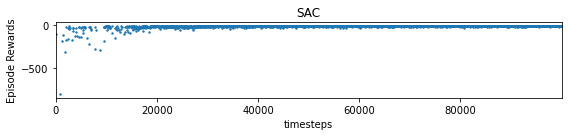

In [683]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "SAC")

In [690]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.savefig('SAC.png')

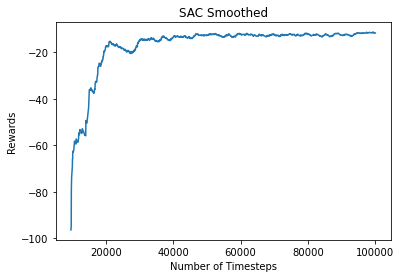

In [691]:
plot_results(log_dir, "SAC")

In [693]:
def plot_results_compare( x_list, y_list, title='Learning Curve'):
    ys = []
    xs = []
    ys.append(moving_average(y_list[0], window=50))
    ys.append(moving_average(y_list[1], window=50))
    ys.append(moving_average(y_list[2], window=50))
#     ys.append(moving_average(y_list[3], window=50))
    
    xs.append(x_list[0][len(x_list[0]) - len(ys[0]):])
    xs.append(x_list[1][len(x_list[1]) - len(ys[1]):])
    xs.append(x_list[2][len(x_list[2]) - len(ys[2]):])
#     xs.append(x_list[2][len(x_list[3]) - len(ys[3]):])
    l1=plt.plot(xs[0],ys[0],'r--',label='PPO')
    l2=plt.plot(xs[1],ys[1],'g--',label='SAC')
    l3=plt.plot(xs[2],ys[2],'b--',label='TQC')
#     l4=plt.plot(xs[0],ys[3],'y--',label='A2C')
    plt.plot(xs[0],ys[0],'r',xs[1],ys[1],'g',xs[2],ys[2],'b')
    plt.title('Learning Curve Comparison')
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.legend()
    # plt.show()
    plt.savefig('learning_curve_comparison.png')
    

In [684]:
x_SAC, y_SAC = ts2xy(load_results(log_dir), 'timesteps')

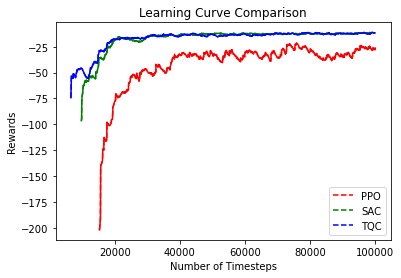

In [694]:
plot_results_compare(x_list, y_list)